In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output
from datetime import datetime
import time
import traceback
from tqdm.notebook import tqdm, trange
import warnings
import sys
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

try:
    from pathlib import Path
    sys.path.append(str(Path.cwd().parent))
except:
    print("warning: cannot automatically add project root to path. if import error, please manually set the path.")


try:
    from testing.factor_framework import (
        price_to_vwap_factor, momentum_factor, volume_factor, volatility_factor, 
        rsi_factor, macd_factor, buy_sell_pressure_factor,
        trade_activity_factor, price_impact_factor, liquidity_imbalance_factor,
        trading_efficiency_factor, volume_divergence_factor, vpin_factor,
        hl_volume_position_factor, trade_size_change_factor, 
        market_balance_factor, smart_momentum_factor, trading_quality_factor, 
        liquidity_risk_factor, test_factor, backtest_factor,
        # 數據處理函數
        winsorize_factor, standardize_factor, neutralize_factor, rank_transform_factor,
        calculate_vwap, load_data, calculate_forward_returns
    )
    # 導入特徵選擇相關函數和類
    from testing.factor_framework.feature_selection import TwoStageFeatureSelector, LassoFeatureSelector, XGBoostFeatureSelector
except ImportError as e:
    print(f"import error: {e}")
    print("please ensure the factor_framework module is available, or adjust the import path")



In [2]:
# 設置配置參數 - 可以根據需要調整
config = {
    'periods': [4, 8, 12, 24, 48],  # 預測時間窗口（小時）
    'vwap_window': 6,       # VWAP窗口
    'top_n_factors': 10,    # 選擇前N個因子
    'neutralization': False,  # 是否中性化因子
    'winsorize': True,      # 是否去極值
    'standardize': True,     # 是否標準化
    'use_subset': False,     # 是否使用數據子集
    'max_symbols': 9,       # 最大交易對數量
    'days_to_use': 720,      # 使用的天數
    'verbose': True,        # 是否打印詳細日誌
    'rank_transform': True, # 是否進行排名轉換
    'min_unique_values': 20, # 因子所需的最小唯一值數量
    
    # 兩階段特徵選擇配置
    'cv_folds': 5,          # 交叉驗證折數
    'random_state': 42,     # 隨機種子
    'top_n_lasso': 30,      # Lasso選擇的最大特徵數
    'top_n_final': 15,      # 最終選擇的最大特徵數
    
    'factor_categories': {  
        'Price': ['price_to_vwap', 'momentum_24h'],
        'Volume': ['volume_24h', 'volume_divergence'],
        'Volatility': ['volatility_5d', 'bb_width'],
        'Technical': ['rsi_3d', 'macd_line', 'macd_histogram'],
        'Crypto-specific': [
            'buy_sell_pressure', 'trade_activity', 'price_impact',
            'liquidity_imbalance', 'trading_efficiency', 'vpin',
            'hl_volume_position', 'trade_size_change'
        ],
        'Combined': [
            'market_balance', 'smart_momentum', 'trading_quality', 'liquidity_risk'
        ]
    }
}


In [3]:

def calculate_returns(df, target_column='close', periods=[4, 8, 12, 24, 48]):
    
    returns = pd.DataFrame(index=df.index)
    
    for period in periods:
        # 計算未來收益率: (未來價格 / 當前價格) - 1
        future_return = df[target_column].shift(-period) / df[target_column] - 1
        returns[f'future_return_{period}'] = future_return
        
    return returns

# 數據文件路徑 - 根據實際位置調整
data_path = "/Users/mouyasushi/Desktop/Factor_ML/data/futures/all.csv"

# 時間戳 - 用於記錄
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")



df = load_data(data_path)
df_gp = df.groupby('symbol')





<Axes: xlabel='open_time'>

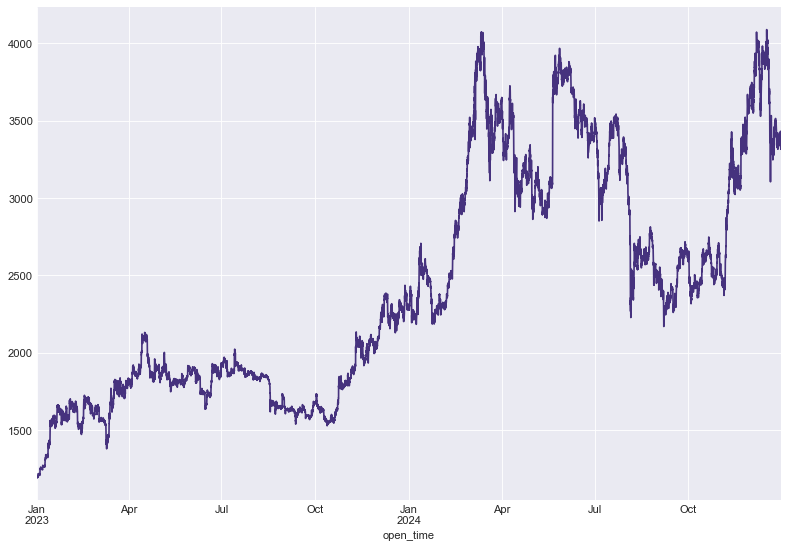

In [4]:
eth = df_gp.get_group('ETHUSDT')
btc = df_gp.get_group('BTCUSDT')
eth['close'].plot()

<Axes: xlabel='open_time'>

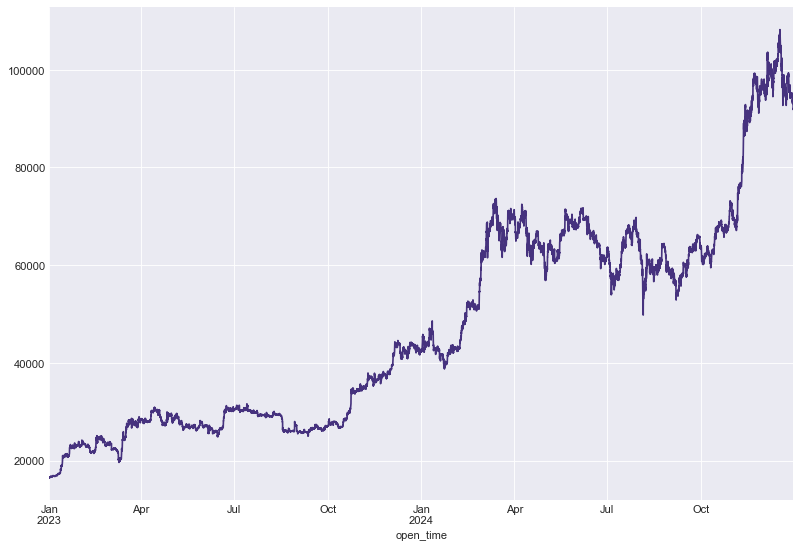

In [5]:
btc['close'].plot()

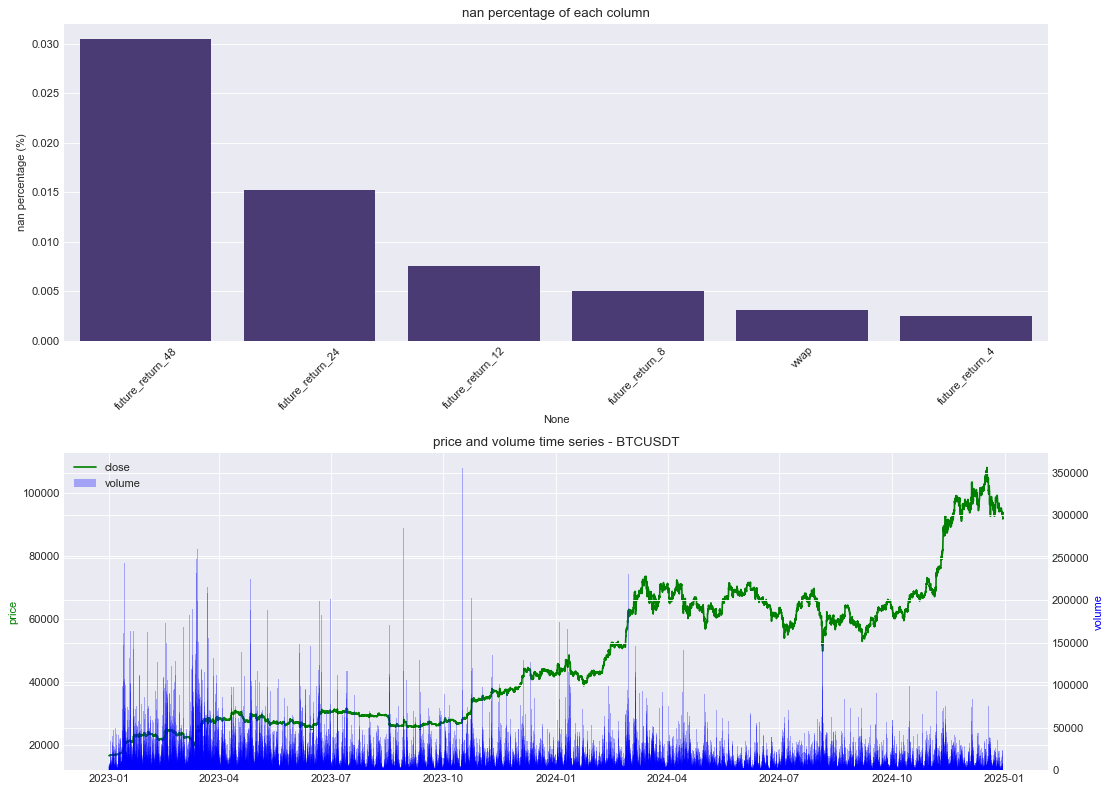

In [6]:
if config['use_subset']:
    
    # 按交易對過濾
    if 'symbol' in df.columns:
        symbols = df['symbol'].unique()
        # 過濾只使用子集交易對
        if len(symbols) > config['max_symbols']:
            display(HTML(f"<p>過濾只使用 {config['max_symbols']} 個交易對(共 {len(symbols)} 個)</p>"))
            df = df[df['symbol'].isin(symbols[:config['max_symbols']])]
    
    # 按時間過濾
    if config['days_to_use'] > 0:
        end_date = df.index.max()
        start_date = end_date - pd.Timedelta(days=config['days_to_use'])
        
        df = df[df.index >= start_date]
    
    display(HTML(f"<p>子集數據形狀: {df.shape}</p>"))
    display(HTML(f"<p>子集時間範圍: {df.index.min()} 到 {df.index.max()}</p>"))
    if 'symbol' in df.columns:
        display(HTML(f"<p>子集交易對: {', '.join(df['symbol'].unique())}</p>"))


# 基本預處理
df = df.sort_index()
df = calculate_vwap(df, window=config['vwap_window'])

# 計算未來收益率
forward_returns = calculate_returns(df, periods=config['periods'])
df = pd.concat([df, forward_returns], axis=1)

# 可視化數據質量
fig = plt.figure(figsize=(14, 10))

# 1. 缺失值熱圖
plt.subplot(2, 1, 1)
missing = df.isna().sum() / len(df) * 100
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    sns.barplot(x=missing.index, y=missing.values)
    plt.title('nan percentage of each column')
    plt.xticks(rotation=45)
    plt.ylabel('nan percentage (%)')
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, 'no nan', ha='center', va='center', fontsize=14)
    



# simple plot for price and vol 
# 2. 價格和成交量時間序列
plt.subplot(2, 1, 2)
if 'symbol' in df.columns:
    # 如果有多個交易對，選擇一個來可視化
    symbols = df['symbol'].unique()
    selected_symbol = symbols[0]
    sample_df = df[df['symbol'] == selected_symbol].copy()
    plt.title(f'price and volume time series - {selected_symbol}')
else:
    sample_df = df.copy()
    plt.title('price and volume time series')
    
ax1 = plt.gca()
ax2 = ax1.twinx()

# 繪製價格
ax1.plot(sample_df.index, sample_df['close'], 'g-', label='close')
ax1.set_ylabel('price', color='g')

# 繪製成交量
ax2.bar(sample_df.index, sample_df['volume'], alpha=0.3, color='b', label='volume')
ax2.set_ylabel('volume', color='b')

# 創建合併圖例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()



In [7]:
# 打印數據質量信息
display(HTML(f"<p>預處理後數據形狀: {df.shape}</p>"))
missing_values = df.isna().sum()
missing_html = "<ul>"
for col, missing in missing_values.items():
    if missing > 0:
        missing_html += f"<li>{col}: {missing} 缺失值 ({missing/len(df)*100:.2f}%)</li>"
missing_html += "</ul>"
display(HTML("<p>每列缺失值數量:</p>" + missing_html))



In [8]:

factor_data = []

try:
    # 價格相關因子
    try:
        price_vwap = price_to_vwap_factor(df, vwap_mean_window=6)
        factor_data.append(("price_to_vwap", price_vwap))
        display(HTML("<p>生成價格/VWAP因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成價格/VWAP因子出錯: {e}</p>"))

    # 動量因子 - 使用不同時間週期
    try:
        for window in [8, 12, 24]:
            momentum = momentum_factor(df, window=window)
            factor_data.append((f"momentum_{window}h", momentum))
        display(HTML("<p>生成動量因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成動量因子出錯: {e}</p>"))

    # 成交量因子 - 使用不同時間週期
    try:
        for window in [8, 12, 24]:
            volume = volume_factor(df, window=window)
            factor_data.append((f"volume_{window}h", volume))
        display(HTML("<p>生成成交量因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成成交量因子出錯: {e}</p>"))

    # 波動率因子 - 使用不同時間週期
    try:
        for window in [8, 12, 24]:
            vol = volatility_factor(df, window=window)
            factor_data.append((f"volatility_{window}h", vol))
        display(HTML("<p>生成波動率因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成波動率因子出錯: {e}</p>"))

    # RSI因子 - 使用不同時間週期
    try:
        for window in [8, 12, 24]:
            rsi = rsi_factor(df, window=window)
            factor_data.append((f"rsi_{window}h", rsi))
        display(HTML("<p>生成RSI因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成RSI因子出錯: {e}</p>"))

    
    # MACD因子
    try:
        macd_factor_result = macd_factor(df, fast=2*6, slow=6*6, signal=3*6)
        if isinstance(macd_factor_result, dict) or isinstance(macd_factor_result, pd.DataFrame):
            factor_data.append(("macd_line", macd_factor_result['macd_line']))
            factor_data.append(("macd_signal", macd_factor_result['signal_line']))
            factor_data.append(("macd_histogram", macd_factor_result['macd_histogram']))
        else:
            macd_line, macd_signal, macd_hist = macd_factor_result
            factor_data.append(("macd_line", macd_line))
            factor_data.append(("macd_signal", macd_signal))
            factor_data.append(("macd_histogram", macd_hist))
        display(HTML("<p>生成MACD因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成MACD因子出錯: {e}</p>"))
        # 使用隨機值作為替代
        macd_line = pd.Series(np.random.randn(len(df.index)), index=df.index)
        macd_signal = pd.Series(np.random.randn(len(df.index)), index=df.index)
        macd_hist = pd.Series(np.random.randn(len(df.index)), index=df.index)
        factor_data.append(("macd_line", macd_line))
        factor_data.append(("macd_signal", macd_signal))
        factor_data.append(("macd_histogram", macd_hist))
        display(HTML("<p style='color:orange'>使用隨機值替代MACD因子</p>"))

    # 加密貨幣特定因子 - 每種因子使用標準窗口
    try:
        bs_pressure = buy_sell_pressure_factor(df, window=24)
        factor_data.append(("buy_sell_pressure", bs_pressure))
        display(HTML("<p>生成買賣壓力因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成買賣壓力因子出錯: {e}</p>"))

    try:
        trade_activity = trade_activity_factor(df, window=24)
        factor_data.append(("trade_activity", trade_activity))
        display(HTML("<p>生成交易活動因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成交易活動因子出錯: {e}</p>"))

    try:
        price_impact = price_impact_factor(df, window=24)
        factor_data.append(("price_impact", price_impact))
        display(HTML("<p>生成價格影響因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成價格影響因子出錯: {e}</p>"))

    try:
        liq_imbalance = liquidity_imbalance_factor(df, window=24)
        factor_data.append(("liquidity_imbalance", liq_imbalance))
        display(HTML("<p>生成流動性不平衡因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成流動性不平衡因子出錯: {e}</p>"))

    try:
        trading_eff = trading_efficiency_factor(df, window=24)
        factor_data.append(("trading_efficiency", trading_eff))
        display(HTML("<p>生成交易效率因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成交易效率因子出錯: {e}</p>"))

    try:
        vol_div = volume_divergence_factor(df, window=24)
        factor_data.append(("volume_divergence", vol_div))
        display(HTML("<p>生成成交量背離因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成成交量背離因子出錯: {e}</p>"))

    try:
        vpin = vpin_factor(df, window=24, buckets=12)
        factor_data.append(("vpin", vpin))
        display(HTML("<p>生成VPIN因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成VPIN因子出錯: {e}</p>"))

    try:
        hlvp = hl_volume_position_factor(df, window=24)
        factor_data.append(("hl_volume_position", hlvp))
        display(HTML("<p>生成高低成交量位置因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成高低成交量位置因子出錯: {e}</p>"))

    try:
        tsc = trade_size_change_factor(df, window=24)
        factor_data.append(("trade_size_change", tsc))
        display(HTML("<p>生成交易規模變化因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成交易規模變化因子出錯: {e}</p>"))

    

    # 組合因子
    try:
        mb = market_balance_factor(df, window=24)
        factor_data.append(("market_balance", mb))
        display(HTML("<p>生成市場平衡因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成市場平衡因子出錯: {e}</p>"))

    try:
        sm = smart_momentum_factor(df, window=24, volume_weight=0.3)
        factor_data.append(("smart_momentum", sm))
        display(HTML("<p>生成智能動量因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成智能動量因子出錯: {e}</p>"))

    try:
        tq = trading_quality_factor(df, window=24)
        factor_data.append(("trading_quality", tq))
        display(HTML("<p>生成交易質量因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成交易質量因子出錯: {e}</p>"))

    try:
        lr = liquidity_risk_factor(df, window=24)
        factor_data.append(("liquidity_risk", lr))
        display(HTML("<p>生成流動性風險因子</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red'>生成流動性風險因子出錯: {e}</p>"))
except Exception as e:
    display(HTML(f"<p style='color:red'>生成因子時出現錯誤: {e}</p>"))
    traceback.print_exc()

# 顯示因子數量
display(HTML(f"<p>成功生成 {len(factor_data)} 個因子</p>"))



In [9]:
factor_data

[('price_to_vwap',
  open_time
  2023-01-01 00:00:00            NaN
  2023-01-01 00:00:00            NaN
  2023-01-01 00:00:00            NaN
  2023-01-01 00:00:00            NaN
  2023-01-01 00:00:00            NaN
                            ...     
  2024-12-30 16:00:00   -3330.431870
  2024-12-30 16:00:00       8.573632
  2024-12-30 16:00:00    -178.516992
  2024-12-30 16:00:00     -11.376491
  2024-12-30 16:00:00       8.007942
  Length: 157617, dtype: float64),
 ('momentum_8h',
  open_time
  2023-01-01 00:00:00            NaN
  2023-01-01 00:00:00            NaN
  2023-01-01 00:00:00            NaN
  2023-01-01 00:00:00            NaN
  2023-01-01 00:00:00            NaN
                            ...     
  2024-12-30 16:00:00    1649.306415
  2024-12-30 16:00:00      -0.012748
  2024-12-30 16:00:00      -0.997967
  2024-12-30 16:00:00      -0.970857
  2024-12-30 16:00:00       0.000683
  Name: close, Length: 157617, dtype: float64),
 ('momentum_12h',
  open_time
  2023-01-01 

factors_data = list(tuples(name, val(series)))

In [10]:
name, val = factor_data[0]
print(name)
print(type(val))
print(val)


price_to_vwap
<class 'pandas.core.series.Series'>
open_time
2023-01-01 00:00:00            NaN
2023-01-01 00:00:00            NaN
2023-01-01 00:00:00            NaN
2023-01-01 00:00:00            NaN
2023-01-01 00:00:00            NaN
                          ...     
2024-12-30 16:00:00   -3330.431870
2024-12-30 16:00:00       8.573632
2024-12-30 16:00:00    -178.516992
2024-12-30 16:00:00     -11.376491
2024-12-30 16:00:00       8.007942
Length: 157617, dtype: float64


In [11]:
# 將因子數據轉換為字典格式，以便後續分析
factors = {}
for name, factor in factor_data:
    factors[name] = factor

factors.keys()

dict_keys(['price_to_vwap', 'momentum_8h', 'momentum_12h', 'momentum_24h', 'volume_8h', 'volume_12h', 'volume_24h', 'volatility_8h', 'volatility_12h', 'volatility_24h', 'rsi_8h', 'rsi_12h', 'rsi_24h', 'macd_line', 'macd_signal', 'macd_histogram', 'buy_sell_pressure', 'trade_activity', 'price_impact', 'liquidity_imbalance', 'trading_efficiency', 'volume_divergence', 'vpin', 'hl_volume_position', 'trade_size_change', 'market_balance', 'smart_momentum', 'trading_quality', 'liquidity_risk'])

plot factors 

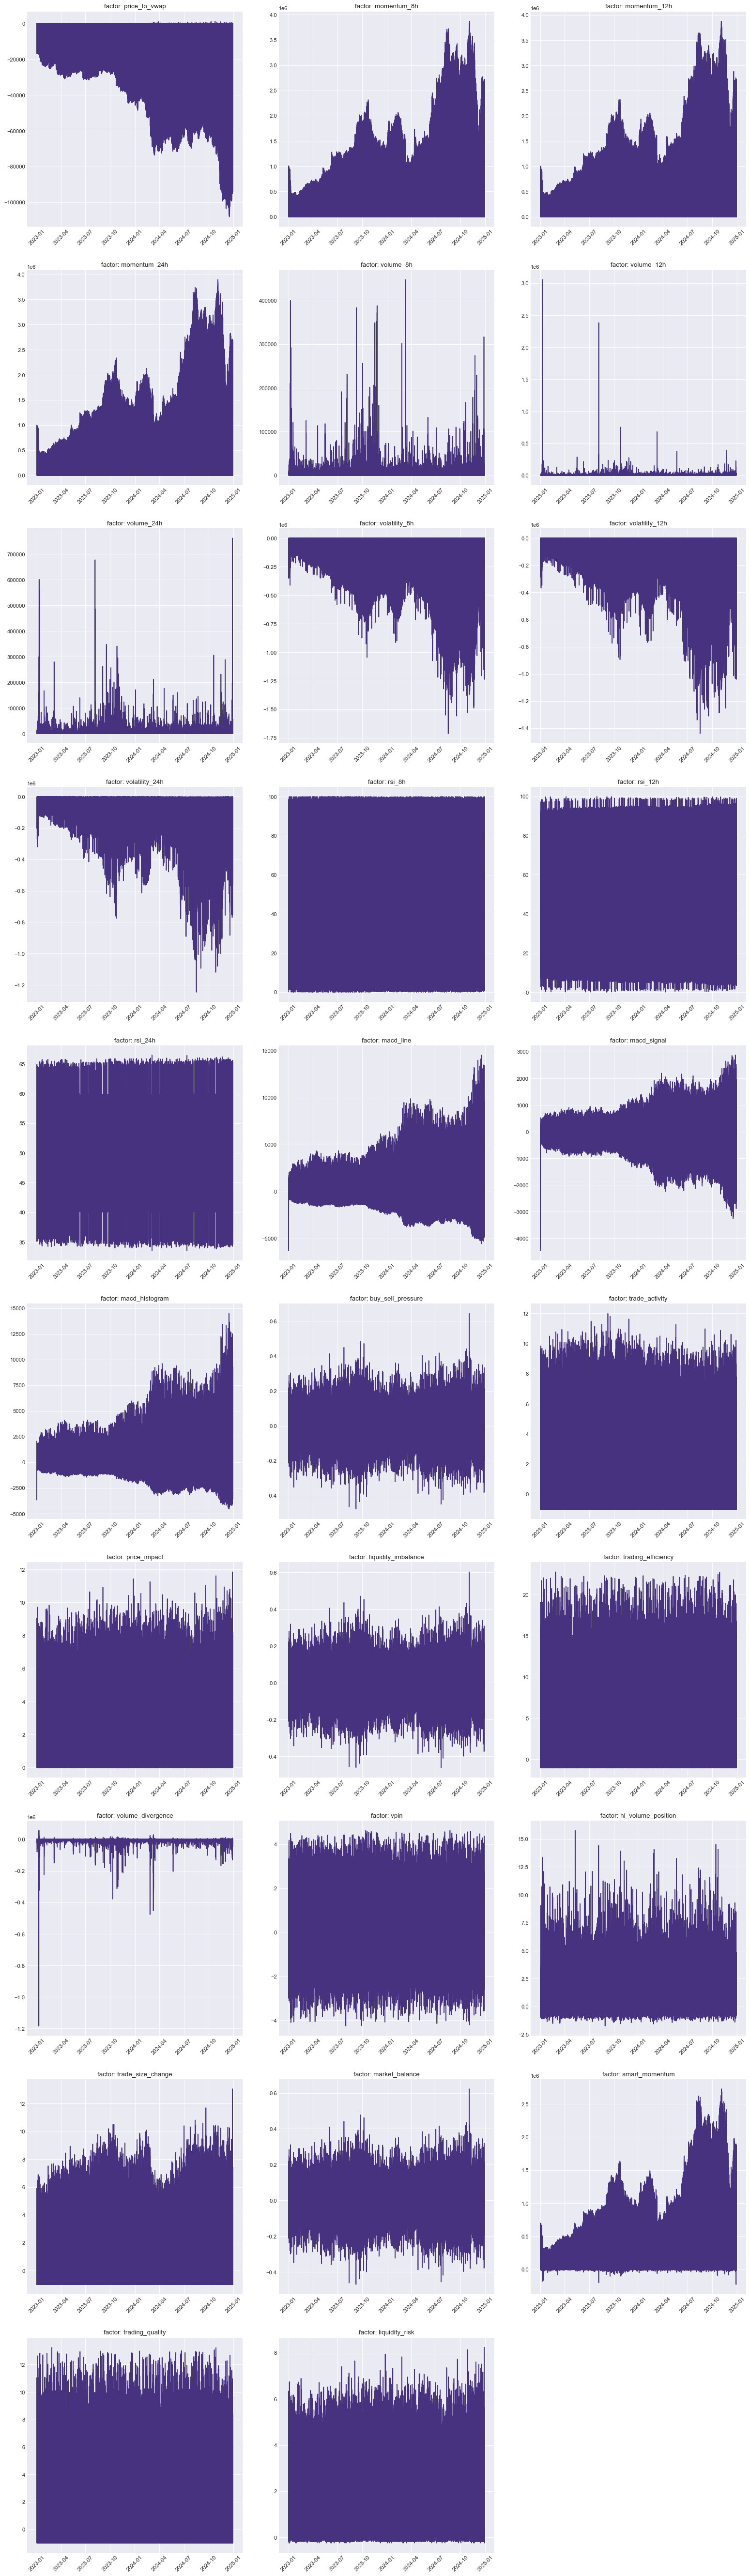

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# 创建多个子图
plt.figure(figsize=(20, 100))  # 调整大小以适应所有因子

# 获取因子数量
n_factors = len(factors)
rows = (n_factors + 2) // 2  

# 循环绘制每个因子
for i, (name, factor) in enumerate(factors.items(), 1):
    # 创建子图
    plt.subplot(rows, 3, i)
    
    # 确保因子是Series类型
    if isinstance(factor, pd.Series):
        factor_series = factor
    else:
        # 尝试转换为Series
        
        factor_series = pd.Series(factor)
        
    # 绘制时间序列
    plt.plot(factor_series.index, factor_series.values)
    plt.title(f'factor: {name}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.tight_layout(pad=3.0)
plt.show()

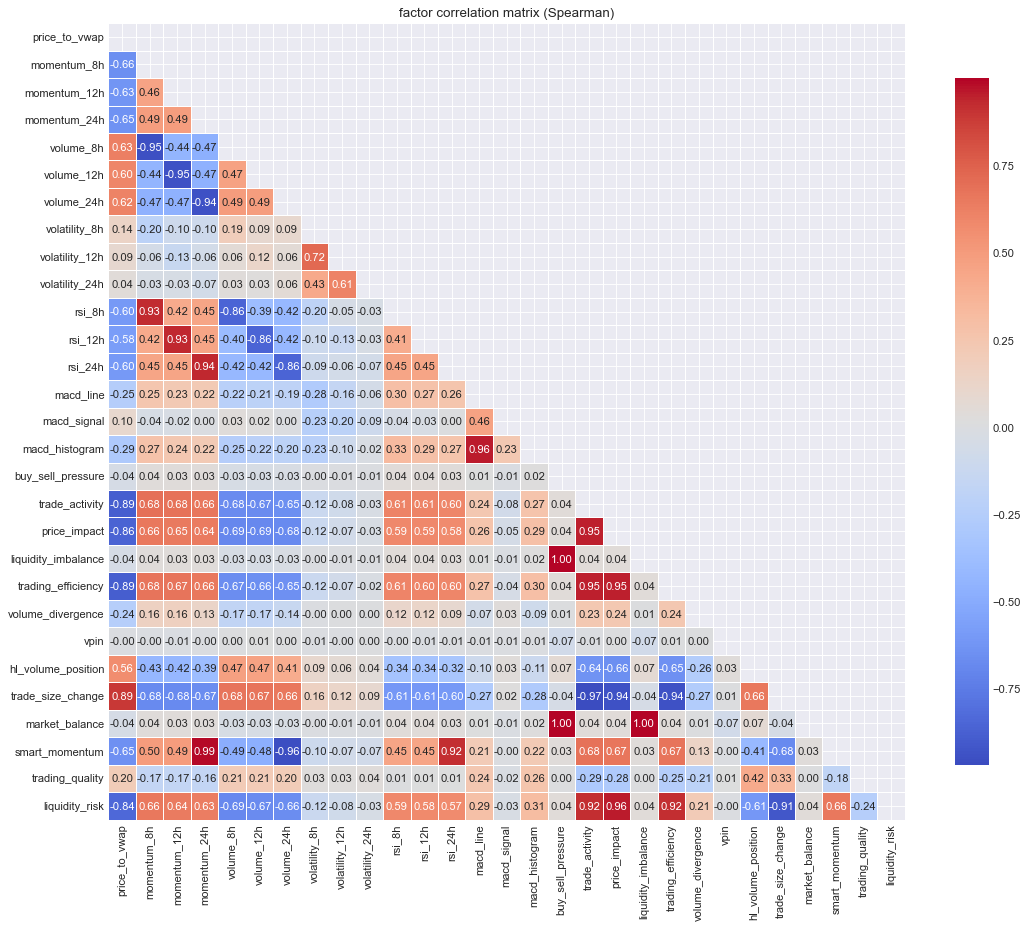

In [13]:

# 可視化因子相關性
display(HTML("<p>analyze factor correlation...</p>"))
factor_df = pd.DataFrame()

# 將所有因子轉換為DataFrame
for name, factor in factors.items():
    if isinstance(factor, pd.Series):
        factor_df[name] = factor
    elif isinstance(factor, pd.DataFrame):
        # 如果因子是DataFrame，使用第一列
        factor_df[name] = factor.iloc[:, 0]
    elif hasattr(factor, 'mask') and hasattr(factor, 'data'):
        # 處理MaskedArray
        series = pd.Series(factor.data, index=df.index)
        if hasattr(factor, 'mask'):
            mask = factor.mask if isinstance(factor.mask, np.ndarray) else np.array(factor.mask)
            series[mask] = np.nan
        factor_df[name] = series

# 計算相關矩陣
corr_matrix = factor_df.corr(method='spearman')

# 繪製相關熱圖
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, 
           fmt='.2f', square=True, linewidths=.5, cbar_kws={'shrink': .8})
plt.title('factor correlation matrix (Spearman)')
plt.tight_layout()
plt.show()



In [14]:
factor_df


,price_to_vwap,momentum_8h,momentum_12h,momentum_24h,volume_8h,volume_12h,volume_24h,volatility_8h,volatility_12h,volatility_24h,...,liquidity_imbalance,trading_efficiency,volume_divergence,vpin,hl_volume_position,trade_size_change,market_balance,smart_momentum,trading_quality,liquidity_risk
open_time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 16:00:00,-3330.431870,1649.306415,16.833956,0.000980,-0.999064,-0.912461,-0.710454,-963006.643356,-786978.983507,-556666.394434,...,0.008360,-0.943712,1305.973600,-0.354527,-0.313315,-0.999747,0.008649,0.000771,-0.966126,0.429568
2024-12-30 16:00:00,8.573632,-0.012748,-0.999990,-1.000000,-0.386082,941.730048,13203.509633,-963006.644214,-786979.457774,-556666.648036,...,-0.080039,-1.000000,-1236.022624,0.032950,0.448260,3.595048,-0.081484,-3962.051466,0.838019,-0.059515
2024-12-30 16:00:00,-178.516992,-0.997967,8.223076,5503.557483,25.934750,-0.633218,-0.998681,-16018.510177,-786830.897356,-556616.492880,...,0.073333,-0.999982,395.835547,0.095668,-0.317376,-0.995005,0.074458,3854.668247,-0.997991,0.081923


In [15]:
# 顯示因子質量信息
display(HTML("<h4>factor quality information:</h4>"))
factor_info_html = "<table border='1'><tr><th>factor name</th><th>unique value count</th><th>missing value count</th><th>missing percentage</th></tr>"

for name, factor in factors.items():
    # 轉換MaskedArray為Series
    if hasattr(factor, 'mask') and hasattr(factor, 'data'):
        factor_series = pd.Series(factor.data, index=df.index)
        if hasattr(factor, 'mask'):
            mask = factor.mask if isinstance(factor.mask, np.ndarray) else np.array(factor.mask)
            factor_series[mask] = np.nan
    elif isinstance(factor, pd.Series):
        factor_series = factor
    else:
        factor_series = pd.Series(factor, index=df.index)
        
    unique_count = len(factor_series.dropna().unique())
    missing_count = factor_series.isna().sum()
    missing_percent = missing_count/len(factor_series)*100
    
    # 根據唯一值和缺失值比例設置顏色
    color = "green"
    if unique_count < 10:
        color = "red"
    elif unique_count < 50:
        color = "orange"
        
    factor_info_html += f"<tr><td>{name}</td><td style='color:{color}'>{unique_count}</td><td>{missing_count}</td><td>{missing_percent:.2f}%</td></tr>"

factor_info_html += "</table>"
display(HTML(factor_info_html))





factor name,unique value count,missing value count,missing percentage
price_to_vwap,157606,11,0.01%
momentum_8h,157274,9,0.01%
momentum_12h,157240,13,0.01%
momentum_24h,157297,25,0.02%
volume_8h,157608,9,0.01%
volume_12h,157604,13,0.01%
volume_24h,157592,25,0.02%
volatility_8h,157607,9,0.01%
volatility_12h,157604,13,0.01%
volatility_24h,157586,25,0.02%


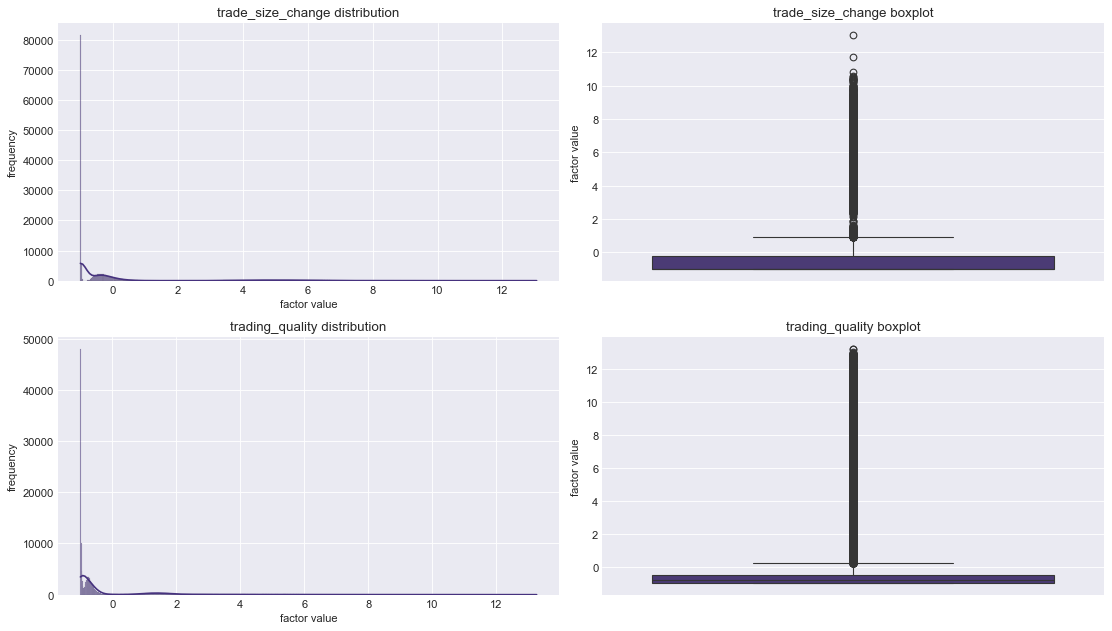

In [16]:
selected_viz_factors = ['trade_size_change', 'trading_quality']
fig, axes = plt.subplots(len(selected_viz_factors), 2, figsize=(14, 4*len(selected_viz_factors)))

for i, name in enumerate(selected_viz_factors):
    factor = factors[name]
    
    # 轉換為Series
    if hasattr(factor, 'mask') and hasattr(factor, 'data'):
        factor_series = pd.Series(factor.data, index=df.index)
        if hasattr(factor, 'mask'):
            mask = factor.mask if isinstance(factor.mask, np.ndarray) else np.array(factor.mask)
            factor_series[mask] = np.nan
    elif isinstance(factor, pd.Series):
        factor_series = factor
    else:
        factor_series = pd.Series(factor, index=df.index)
    
    # 1. 因子分布直方圖
    sns.histplot(factor_series.dropna(), kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{name} distribution')
    axes[i, 0].set_xlabel('factor value')
    axes[i, 0].set_ylabel('frequency')
    
    # 2. 因子箱型圖
    sns.boxplot(y=factor_series.dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'{name} boxplot')
    axes[i, 1].set_ylabel('factor value')

plt.tight_layout()
plt.show()






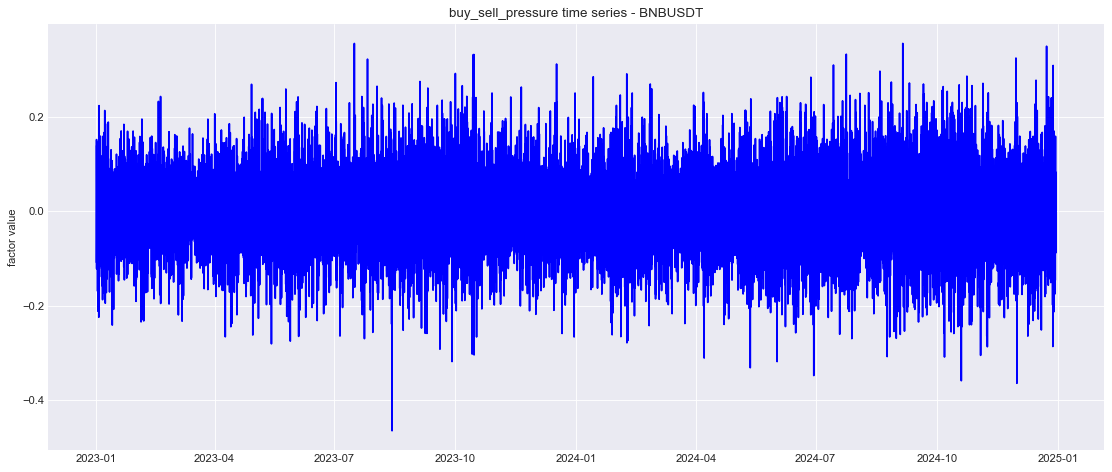

In [17]:
plt.figure(figsize=(14, 6))
factor_name = 'buy_sell_pressure'
factor = factors[factor_name]

# 轉換為Series
if hasattr(factor, 'mask') and hasattr(factor, 'data'):
    factor_series = pd.Series(factor.data, index=df.index)
    if hasattr(factor, 'mask'):
        mask = factor.mask if isinstance(factor.mask, np.ndarray) else np.array(factor.mask)
        factor_series[mask] = np.nan
elif isinstance(factor, pd.Series):
    factor_series = factor
else:
    factor_series = pd.Series(factor, index=df.index)

# 如果有多個交易對，選擇一個來可視化
if 'symbol' in df.columns:
    symbols = df['symbol'].unique()
    selected_symbol = symbols[1]
    mask = df['symbol'] == selected_symbol
    factor_to_plot = factor_series[mask]
    plt.title(f'{factor_name} time series - {selected_symbol}')
else:
    factor_to_plot = factor_series
    plt.title(f'{factor_name} time series')

plt.plot(factor_to_plot.index, factor_to_plot.values, 'b-')
plt.ylabel('factor value')
plt.grid(True)
plt.tight_layout()
plt.show()




deal with each factor:   0%|          | 0/29 [00:00<?, ?it/s]

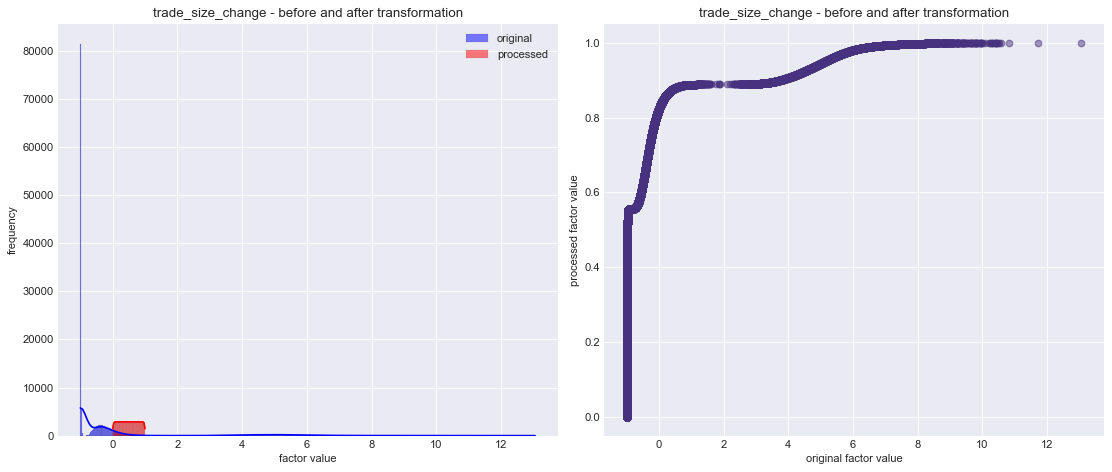

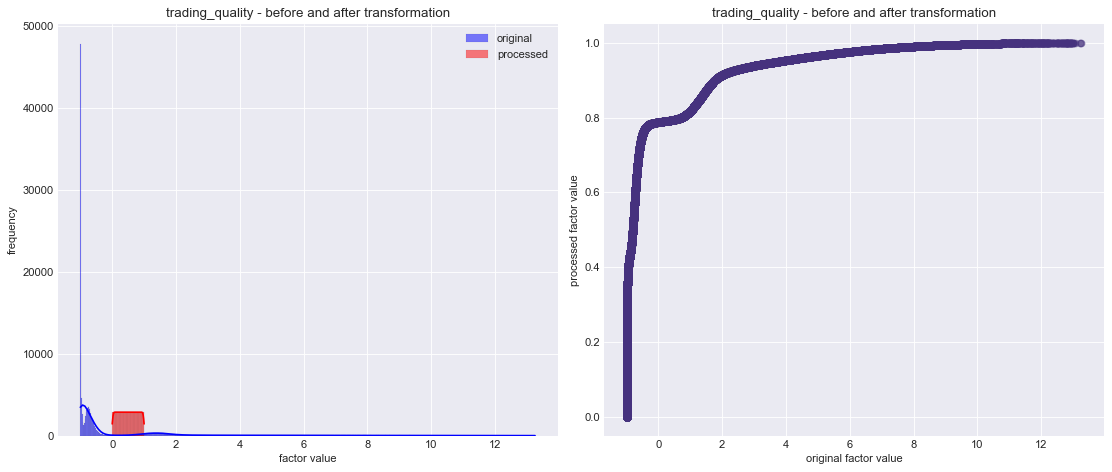

In [18]:
%load_ext autoreload
%autoreload 2


# 儲存原始因子 (用於比較)
original_factors = {}
for name, factor in factors.items():
    if isinstance(factor, pd.Series):
        original_factors[name] = factor.copy()
    elif hasattr(factor, 'mask') and hasattr(factor, 'data'):
        # 處理MaskedArray
        factor_series = pd.Series(factor.data, index=df.index)
        if hasattr(factor, 'mask'):
            mask = factor.mask if isinstance(factor.mask, np.ndarray) else np.array(factor.mask)
            factor_series[mask] = np.nan
        original_factors[name] = factor_series.copy()
    else:
        try:
            original_factors[name] = pd.Series(factor, index=df.index).copy()
        except:
            pass
        


config['neutralization'] = False

# 然後運行原來的處理因子代碼
for name in tqdm(factors.keys(), desc="deal with each factor"):
    factor = factors[name]
    
    # 處理不同類型的因子
    if not isinstance(factor, pd.Series):
        try:
            # 處理MaskedArray
            if hasattr(factor, 'mask') and hasattr(factor, 'data'):
                factor_series = pd.Series(factor.data, index=df.index)
                if hasattr(factor, 'mask'):
                    mask = factor.mask if isinstance(factor.mask, np.ndarray) else np.array(factor.mask)
                    factor_series[mask] = np.nan
                factor = factor_series
            # 處理DataFrame
            elif isinstance(factor, pd.DataFrame):
                factor = factor.iloc[:, 0]
            # 嘗試直接轉換為Series
            else:
                factor = pd.Series(factor, index=df.index)
        except Exception as e:
            display(HTML(f"<p style='color:red'>deal with factor {name} error: {e}</p>"))
            continue
    
    # 檢查並修復非數值問題
    if factor.dtype == 'object' or isinstance(factor.iloc[0], str):
        try:
            display(HTML(f"<p style='color:orange'>因子 {name} 包含字符串值，嘗試轉換為數值</p>"))
            # 嘗試將所有內容轉換為浮點數
            factor = pd.to_numeric(factor, errors='coerce')
            # 如果轉換後全是NaN，則使用隨機值替代
            if factor.isna().all():
                display(HTML(f"<p style='color:red'>因子 {name} 無法轉換為數值，使用隨機值替代</p>"))
                factor = pd.Series(np.random.randn(len(factor)), index=factor.index)
        except Exception as e:
            display(HTML(f"<p style='color:red'>轉換因子 {name} 為數值時出錯: {e}，使用隨機值替代</p>"))
            factor = pd.Series(np.random.randn(len(df.index)), index=df.index)
    
    # 去極值
    if config.get('winsorize', True):
        try:
            factor = winsorize_factor(factor)
        except Exception as e:
            display(HTML(f"<p style='color:red'>去極值處理 {name} 出錯: {e}，跳過此步驟</p>"))
    
    # 中性化
    if config.get('neutralization', False):
        try:
            factor = neutralize_factor(factor, df)
        except Exception as e:
            display(HTML(f"<p style='color:red'>中性化處理 {name} 出錯: {e}，跳過此步驟</p>"))
    
    # 標準化
    if config.get('standardize', True):
        try:
            # 確保為數值類型
            factor = pd.to_numeric(factor, errors='coerce')
            factor = standardize_factor(factor)
        except Exception as e:
            display(HTML(f"<p style='color:red'>標準化處理 {name} 出錯: {e}，跳過此步驟</p>"))
        
    # 排名轉換
    if config.get('rank_transform', True):
        try:
            factor = rank_transform_factor(factor)
        except Exception as e:
            display(HTML(f"<p style='color:red'>排名轉換處理 {name} 出錯: {e}，跳過此步驟</p>"))
        
    # 保存處理後的因子
    factors[name] = factor
    
    
    # visualize factor transformation 
viz_transform_factors = ['trade_size_change', 'trading_quality']

for factor_name in viz_transform_factors:
    # 獲取原始和處理後的因子
    original = original_factors.get(factor_name)
    processed = factors.get(factor_name)
    
    if original is None or processed is None:
        continue
        
    # 可視化轉換過程
    plt.figure(figsize=(14, 6))
    
    # 原始和處理後的分布比較
    plt.subplot(1, 2, 1)
    sns.histplot(original.dropna(), kde=True, color='blue', alpha=0.5, label='original')
    sns.histplot(processed.dropna(), kde=True, color='red', alpha=0.5, label='processed')
    plt.title(f'{factor_name} - before and after transformation')
    plt.xlabel('factor value')
    plt.ylabel('frequency')
    plt.legend()
    
    # 原始和處理後的散點圖
    plt.subplot(1, 2, 2)
    plt.scatter(original.dropna(), processed.dropna(), alpha=0.5)
    plt.title(f'{factor_name} - before and after transformation')
    plt.xlabel('original factor value')
    plt.ylabel('processed factor value')
    
    plt.tight_layout()
    plt.show()





In [19]:
# 執行因子分析
factor_results = {}
valid_factors = []

# 分析每個因子
for name in tqdm(factors.keys(), desc="analyze each factor"):
    factor = factors[name]
    
    try:
        # 檢查因子是否有效
        if factor is None or (isinstance(factor, pd.Series) and factor.isna().all()):
            display(HTML(f"<p style='color:red'>skip invalid factor {name}: all values are NaN</p>"))
            factor_results[name] = {period: {'IC': 0, 't_stat': 0} for period in config['periods']}
            continue
            
        # 檢查是否有足夠的唯一值
        unique_count = len(factor.dropna().unique())
        if unique_count < 5:
            display(HTML(f"<p style='color:orange'>skip factor {name}: only {unique_count} unique values, at least 5</p>"))
            factor_results[name] = {period: {'IC': 0, 't_stat': 0} for period in config['periods']}
            continue
            
        # 測試因子
        results = test_factor(df, factor, periods=config['periods'])
        factor_results[name] = results
        
        # 檢查是否是有效因子(具有非零IC)
        has_valid_ic = False
        for period, result in results.items():
            if 'IC' in result and abs(result['IC']) > 0.01:  # 最小顯著性閾值
                has_valid_ic = True
                break
        
        if has_valid_ic:
            valid_factors.append(name)
    
    except Exception as e:
        display(HTML(f"<p style='color:red'>analyze factor {name} error: {e}</p>"))
        traceback.print_exc()
        # 創建空結果以避免破壞流程
        factor_results[name] = {period: {'IC': 0, 't_stat': 0} for period in config['periods']}

# 顯示有效因子數量
print(f'found {len(valid_factors)} factors with significant IC values: {", ".join(valid_factors)}')
display(HTML(f"<p>found {len(valid_factors)} factors with significant IC values: {', '.join(valid_factors)}</p>"))



analyze each factor:   0%|          | 0/29 [00:00<?, ?it/s]

test_factor execution time: 0.2827 seconds
test_factor executed in 0.2828 seconds
test_factor execution time: 0.2506 seconds
test_factor executed in 0.2506 seconds
test_factor execution time: 0.2712 seconds
test_factor executed in 0.2713 seconds
test_factor execution time: 0.2703 seconds
test_factor executed in 0.2703 seconds
test_factor execution time: 0.2760 seconds
test_factor executed in 0.2761 seconds
test_factor execution time: 0.2786 seconds
test_factor executed in 0.2787 seconds
test_factor execution time: 0.2823 seconds
test_factor executed in 0.2824 seconds
test_factor execution time: 0.2515 seconds
test_factor executed in 0.2516 seconds
test_factor execution time: 0.2463 seconds
test_factor executed in 0.2463 seconds
test_factor execution time: 0.2386 seconds
test_factor executed in 0.2386 seconds
test_factor execution time: 0.2861 seconds
test_factor executed in 0.2862 seconds
test_factor execution time: 0.2808 seconds
test_factor executed in 0.2809 seconds
test_factor exec

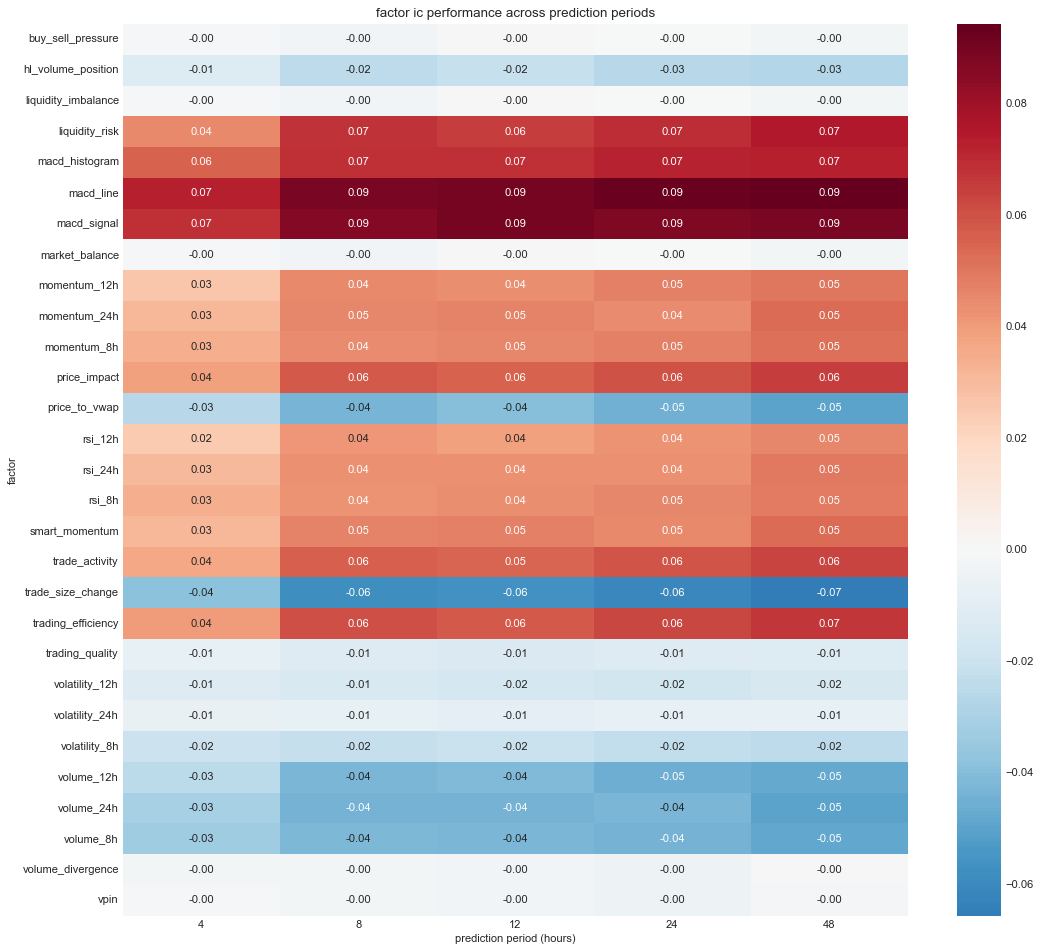

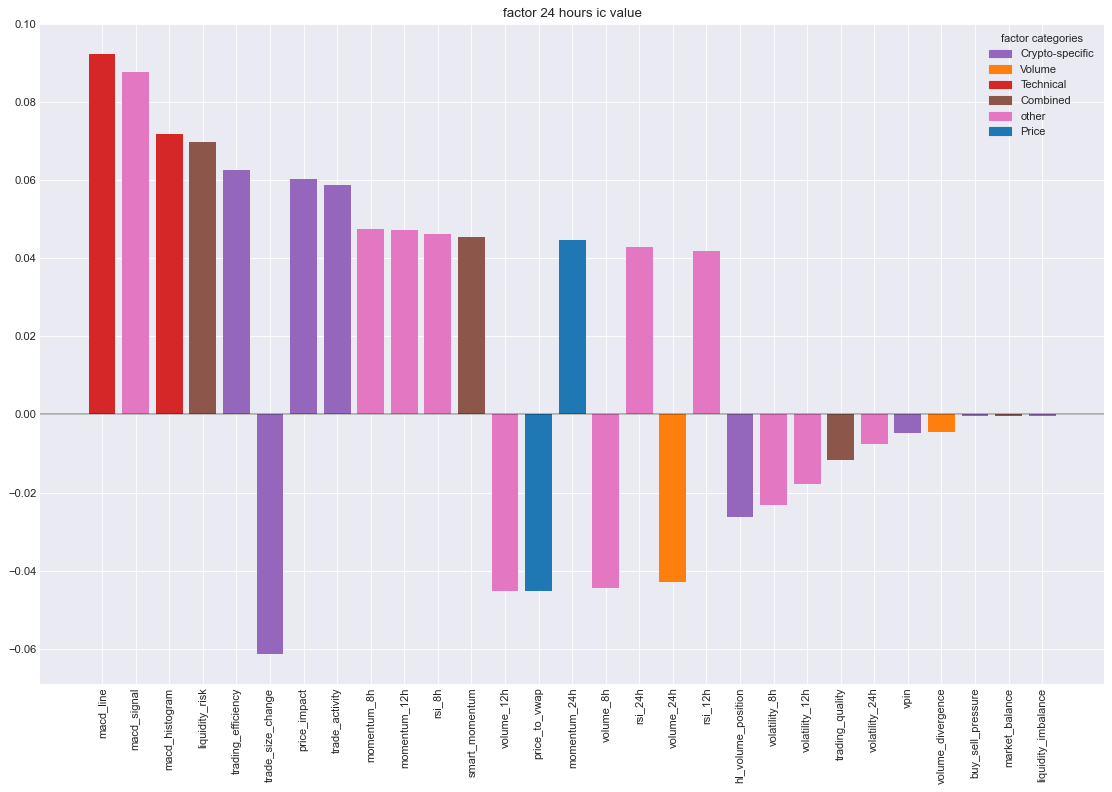

In [20]:
ic_data = []
for factor_name, results in factor_results.items():
    for period, result in results.items():
        if 'IC' in result:
            ic_data.append({
                'factor': factor_name,
                'period': period,
                'IC': result['IC'],
                'abs_IC': abs(result['IC'])
            })



if ic_data:
    ic_df = pd.DataFrame(ic_data)
    
    # 繪製IC熱圖
    plt.figure(figsize=(14, 12))
    
    # 準備數據透視表
    ic_pivot = ic_df.pivot(index='factor', columns='period', values='IC')
    
    # 熱圖
    sns.heatmap(ic_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.2f')
    plt.title('factor ic performance across prediction periods')
    plt.ylabel('factor')
    plt.xlabel('prediction period (hours)')
    plt.tight_layout()
    plt.show()
    
    # 2. 按幅度排序的絕對IC值條形圖
    plt.figure(figsize=(14, 10))
    
    # 選擇24小時或最大期間的IC
    periods = sorted(list({p for results in factor_results.values() for p in results.keys()}))
    if 24 in periods:
        target_period = 24
    else:
        target_period = max(periods)
        
    period_ic = ic_df[ic_df['period'] == target_period].sort_values('abs_IC', ascending=False)
    
    # 按因子類別著色
    colors = []
    categories = []
    
    if 'factor_categories' in config:
        factor_to_category = {}
        for category, factors_list in config['factor_categories'].items():
            for f in factors_list:
                factor_to_category[f] = category
                
        for factor_item in period_ic['factor']:
            found = False
            for category, factors_list in config['factor_categories'].items():
                if factor_item in factors_list:
                    categories.append(category)
                    found = True
                    break
            if not found:
                categories.append('other')
        
        # 創建類別調色板
        palette = sns.color_palette('tab10', n_colors=len(config['factor_categories']) + 1)
        category_colors = {cat: palette[i] for i, cat in enumerate(config['factor_categories'].keys())}
        category_colors['other'] = palette[-1]
        
        colors = [category_colors[cat] for cat in categories]
        
    # 繪製條形圖
    bars = plt.bar(period_ic['factor'], period_ic['IC'], color=colors if colors else None)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'factor {target_period} hours ic value')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # 添加圖例
    if 'factor_categories' in config and categories:
        unique_categories = list(set(categories))
        handles = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in unique_categories]
        plt.legend(handles, unique_categories, title='factor categories')
        
    plt.show()





In [21]:
top_factors = []
if ic_data:
    # 計算平均絕對IC
    avg_ic = {}
    for name, results in factor_results.items():
        ic_values = [abs(result['IC']) for period, result in results.items() if 'IC' in result]
        if ic_values:
            avg_ic[name] = sum(ic_values) / len(ic_values)
    
    # 按IC排序
    sorted_factors = sorted(avg_ic.items(), key=lambda x: x[1], reverse=True)
    
    top_factors = [factor for factor, _ in sorted_factors[:10]]
    
    # 顯示表格
    display(HTML("<h4>top 10 factors ic performance:</h4>"))
    for factor_name in top_factors:
        factor_results_html = f"<h5>factor {factor_name} analysis results:</h5><table border='1'><tr><th>prediction period</th><th>IC value</th><th>t statistic</th></tr>"
        for period, result in factor_results[factor_name].items():
            if 'IC' in result and 't_stat' in result:
                ic_color = "black"
                if abs(result['IC']) > 0.1:
                    ic_color = "green"
                elif abs(result['IC']) > 0.05:
                    ic_color = "blue"                    
                t_color = "black"
                if abs(result['t_stat']) > 2.58:  # 99%顯著性
                    t_color = "green"
                elif abs(result['t_stat']) > 1.96:  # 95%顯著性
                    t_color = "blue"
                    
                factor_results_html += f"<tr><td>{period} hours</td><td style='color:{ic_color}'>{result['IC']:.4f}</td><td style='color:{t_color}'>{result['t_stat']:.4f}</td></tr>"
            else:
                factor_results_html += f"<tr><td>{period} hours</td><td colspan='2'>analysis incomplete, missing indicators</td></tr>"
        
        factor_results_html += "</table>"
        display(HTML(factor_results_html))







prediction period,IC value,t statistic
4 hours,0.0733,-8.1372
8 hours,0.0887,-0.0869
12 hours,0.0902,3.3229
24 hours,0.0923,2.0534
48 hours,0.0942,3.9492


prediction period,IC value,t statistic
4 hours,0.0692,-4.2223
8 hours,0.0863,4.2321
12 hours,0.0895,6.2045
24 hours,0.0876,5.4503
48 hours,0.0888,3.6799


prediction period,IC value,t statistic
4 hours,0.0551,-9.4624
8 hours,0.0686,-3.3216
12 hours,0.0690,-0.3630
24 hours,0.0718,-1.3055
48 hours,0.0732,0.9100


prediction period,IC value,t statistic
4 hours,0.0448,8.4763
8 hours,0.0678,11.2358
12 hours,0.0649,11.5710
24 hours,0.0696,11.6812
48 hours,0.0748,11.5826


prediction period,IC value,t statistic
4 hours,0.0401,3.4504
8 hours,0.0606,6.3317
12 hours,0.0576,4.8295
24 hours,0.0626,5.2362
48 hours,0.0668,7.1834


prediction period,IC value,t statistic
4 hours,-0.0384,-12.6118
8 hours,-0.0589,-21.3847
12 hours,-0.0568,-21.2079
24 hours,-0.0612,-20.6987
48 hours,-0.0658,-22.4338


prediction period,IC value,t statistic
4 hours,0.0381,5.9945
8 hours,0.0576,7.8820
12 hours,0.0550,9.1030
24 hours,0.0603,8.9030
48 hours,0.0648,9.1759


prediction period,IC value,t statistic
4 hours,0.0365,7.4910
8 hours,0.0566,9.6142
12 hours,0.0543,8.4025
24 hours,0.0587,9.4307
48 hours,0.0635,9.1668


prediction period,IC value,t statistic
4 hours,0.0316,1.8760
8 hours,0.0466,7.8569
12 hours,0.0471,5.8122
24 hours,0.0454,5.5889
48 hours,0.0535,7.9848


prediction period,IC value,t statistic
4 hours,0.0341,3.6569
8 hours,0.0447,5.3952
12 hours,0.0457,5.5218
24 hours,0.0474,5.4316
48 hours,0.0520,6.0629


In [22]:
factor_data = []
for name, factor in tqdm(factors.items(), desc="prepare factor data"):
    try:
        # 確保因子是pandas Series
        if not isinstance(factor, pd.Series):
            if hasattr(factor, 'mask') and hasattr(factor, 'data'):
                # 處理MaskedArray
                factor_series = pd.Series(factor.data, index=df.index)
                if hasattr(factor, 'mask'):
                    mask = factor.mask if isinstance(factor.mask, np.ndarray) else np.array(factor.mask)
                    factor_series[mask] = np.nan
                factor = factor_series
            elif isinstance(factor, pd.DataFrame):
                # 如果是DataFrame，使用第一列
                factor = factor.iloc[:, 0]
            else:
                # 嘗試直接轉換為Series
                try:
                    factor = pd.Series(factor, index=df.index)
                except Exception as e:
                    display(HTML(f"<p style='color:red'>cannot convert {name} to Series error: {e}</p>"))
                    continue
        
        # 確保數組是一維的
        if hasattr(factor, 'array') and hasattr(factor.array, 'ndim') and factor.array.ndim > 1:
            # 轉換為一維數組
            try:
                factor = pd.Series(factor.array.to_numpy().flatten(), index=factor.index)
            except Exception as e:
                display(HTML(f"<p style='color:red'>cannot flatten {name} factor error: {e}</p>"))
                continue
        
        # 轉換為數值類型
        factor = pd.to_numeric(factor, errors='coerce')
        
        # 檢查是否有足夠的有效值
        if factor.dropna().size < 10 or len(factor.dropna().unique()) < 5:
            display(HTML(f"<p style='color:orange'>factor {name} has insufficient valid values, skip</p>"))
            continue
            
        # 添加到有效因子列表
        factor_data.append((name, factor))
        
    except Exception as e:
        display(HTML(f"<p style='color:red'>prepare factor {name} error: {e}</p>"))
        continue

if not factor_data:
    display(HTML("<p style='color:red'>no valid factor data for selection</p>"))
else:
    display(HTML(f"<p>prepared {len(factor_data)} valid factors for selection</p>"))





prepare factor data:   0%|          | 0/29 [00:00<?, ?it/s]

In [23]:
factor_data

[('price_to_vwap',
  open_time
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
                           ...   
  2024-12-30 16:00:00    0.130306
  2024-12-30 16:00:00    0.849282
  2024-12-30 16:00:00    0.341979
  2024-12-30 16:00:00    0.454843
  2024-12-30 16:00:00    0.839150
  Length: 157617, dtype: float64),
 ('momentum_8h',
  open_time
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
                           ...   
  2024-12-30 16:00:00    0.861993
  2024-12-30 16:00:00    0.455992
  2024-12-30 16:00:00    0.188791
  2024-12-30 16:00:00    0.290150
  2024-12-30 16:00:00    0.504968
  Name: close, Length: 157617, dtype: float64),
 ('momentum_12h',
  open_time
  2023-01-01 00:00:00         NaN
  2023-01-01 00:00:00         NaN
  2023-01-0

Factor,Average Absolute IC
macd_line,0.0878
macd_signal,0.0843
macd_histogram,0.0675
liquidity_risk,0.0644
trading_efficiency,0.0575
trade_size_change,0.0562
price_impact,0.0552
trade_activity,0.0539
smart_momentum,0.0448
momentum_8h,0.0448


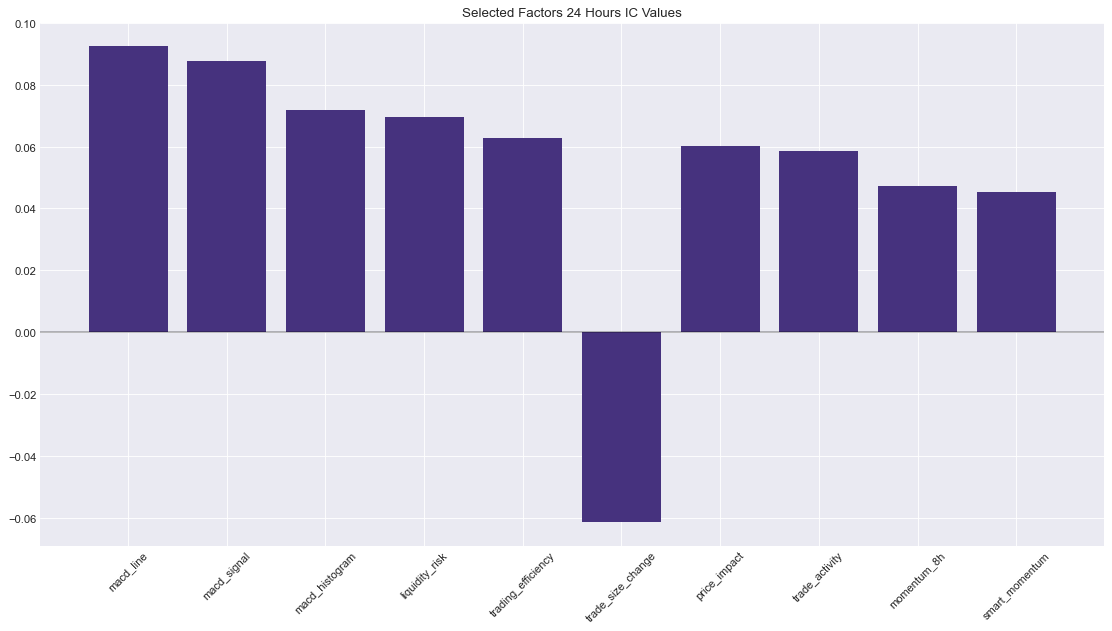

In [24]:
# 使用簡單的IC排序方法選擇因子
display(HTML("<p>Using IC ranking for feature selection...</p>"))

# 為每個因子計算平均絕對IC
avg_ic = {}
for name, results in factor_results.items():
    ic_values = [abs(result['IC']) for period, result in results.items() if 'IC' in result]
    if ic_values:
        avg_ic[name] = sum(ic_values) / len(ic_values)

# 按平均絕對IC排序
sorted_factors_by_ic = sorted(avg_ic.items(), key=lambda x: x[1], reverse=True)

# 選擇前N個因子
top_n = config.get('top_n_factors', min(10, len(sorted_factors_by_ic)))
selected_factors_ic = [factor for factor, _ in sorted_factors_by_ic[:top_n]]

# 顯示結果
display(HTML(f"<h4>Top {top_n} factors selected based on average absolute IC:</h4>"))
ic_sorted_html = "<table border='1'><tr><th>Factor</th><th>Average Absolute IC</th></tr>"
for factor, ic in sorted_factors_by_ic[:top_n]:
    ic_sorted_html += f"<tr><td>{factor}</td><td>{ic:.4f}</td></tr>"
ic_sorted_html += "</table>"
display(HTML(ic_sorted_html))

# 可視化選定因子的IC表現
if selected_factors_ic:
    # 準備數據
    selected_ic_data = [d for d in ic_data if d['factor'] in selected_factors_ic]
    selected_ic_df = pd.DataFrame(selected_ic_data)
    
    # 繪製柱狀圖
    plt.figure(figsize=(14, 8))
    
    # 選擇24小時或最大期間的IC
    if 24 in periods:
        target_period = 24
    else:
        target_period = max(periods)
        
    period_ic = selected_ic_df[selected_ic_df['period'] == target_period].sort_values('abs_IC', ascending=False)
    
    # 繪製條形圖
    bars = plt.bar(period_ic['factor'], period_ic['IC'])
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Selected Factors {target_period} Hours IC Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




### TWo stages Feature selection 

In [25]:
# 準備數據用於機器學習特徵選擇
X_features = pd.DataFrame()

# 收集所有有效因子並轉換為DataFrame
for name, factor in factor_data:
    # 確保因子是有效的
    try:
        if factor is not None and not (isinstance(factor, pd.Series) and factor.isna().all()):
            if isinstance(factor, pd.Series):
                X_features[name] = factor
            else:
                try:
                    X_features[name] = pd.Series(factor)
                except:
                    display(HTML(f"<p style='color:red'>無法將 {name} 轉換為Series, 跳過</p>"))
                    continue
    except Exception as e:
        display(HTML(f"<p style='color:red'>處理因子 {name} 時出錯: {e}, 跳過</p>"))
        continue



In [26]:
# 選定的因子變量
selected_factors = []

# 如果沒有有效因子，使用IC選擇的因子
if X_features.empty:
    display(HTML("<p style='color:orange'>沒有有效因子用於機器學習特徵選擇。使用IC選擇的因子。</p>"))
    selected_factors = selected_factors_ic
else:
    display(HTML(f"<p>已準備 {X_features.shape[1]} 個因子用於機器學習特徵選擇</p>"))
    
    # 選擇目標變量(24小時或最大期間的未來收益)
    if 24 in config['periods']:
        target_col = 'future_return_24'
    else:
        target_col = f'future_return_{max(config["periods"])}'
    
    # 確保目標列存在
    if target_col not in df.columns:
        target_col_candidates = [col for col in df.columns if 'future_return' in col]
        if target_col_candidates:
            target_col = target_col_candidates[0]
            display(HTML(f"<p>使用 {target_col} 作為目標變量</p>"))
        else:
            display(HTML("<p style='color:orange'>未找到未來收益列。計算未來收益...</p>"))
            # 計算未來收益
            future_returns = calculate_returns(df, periods=config['periods'])
            df = pd.concat([df, future_returns], axis=1)
            
            # 重新檢查目標列
            if 24 in config['periods']:
                target_col = 'future_return_24'
            else:
                target_col = f'future_return_{max(config["periods"])}'
                
            if target_col in df.columns:
                display(HTML(f"<p>成功計算未來收益。使用 {target_col} 作為目標變量</p>"))
            else:
                display(HTML("<p style='color:red'>計算未來收益失敗。使用IC選擇的因子。</p>"))
                selected_factors = selected_factors_ic
                target_col = None
    
    if target_col is not None:
        y_target = df[target_col]
        
        # 確保X和y有相同的索引
        common_idx = X_features.index.intersection(y_target.index)
        if len(common_idx) < 100:  # 如果共同索引太少，使用IC選擇的因子
            display(HTML(f"<p style='color:orange'>機器學習特徵選擇的共同數據點太少({len(common_idx)})。使用IC選擇的因子。</p>"))
            selected_factors = selected_factors_ic
        else:
            X = X_features.loc[common_idx]
            y = y_target.loc[common_idx]
            
            # 處理缺失值
            X = X.fillna(0)
            X = X.replace([np.inf, -np.inf], 0)
            y = y.fillna(0)
            
            try:
                # 使用TwoStageFeatureSelector進行特徵選擇
                display(HTML("<p>使用Lasso和XGBoost進行兩階段特徵選擇...</p>"))
                
                # 創建兩階段特徵選擇器
                two_stage_selector = TwoStageFeatureSelector(
                    cv_folds=config['cv_folds'],
                    random_state=config['random_state'],
                    lasso_params={'max_iter': 10000, 'tol': 1e-4, 'n_jobs': -1}, 
                    xgb_params={'n_estimators': 100}
                )
                
                # 執行特徵選擇
                two_stage_selector.fit(
                    X, y, 
                    top_n_lasso=config['top_n_lasso'],
                    top_n_final=config['top_n_final']
                )
                
                # 獲取選定的特徵
                selected_factors_ml = two_stage_selector.final_selected_features_
                
                # 顯示選定的特徵
                display(HTML("<h4>兩階段特徵選擇結果:</h4>"))
                display(HTML(f"<p>Lasso選擇了 {len(two_stage_selector.lasso_selected_features_)} 個特徵</p>"))
                if len(two_stage_selector.lasso_selected_features_) == 0:
                    display(HTML("<p style='color:red'>警告: Lasso沒有選擇任何特徵，請檢查數據或參數設置</p>"))
                    selected_factors = selected_factors_ic
                else:
                    display(HTML(f"<p>XGBoost最終選擇了 {len(selected_factors_ml)} 個特徵</p>"))
                    
                    # 顯示特徵重要性
                    display(HTML("<h4>Lasso特徵重要性:</h4>"))
                    lasso_importance = two_stage_selector.get_lasso_support()
                    lasso_html = "<table border='1'><tr><th>排名</th><th>特徵</th><th>重要性</th></tr>"
                    for i, (feature, imp) in enumerate(lasso_importance.head(10).items(), 1):
                        lasso_html += f"<tr><td>{i}</td><td>{feature}</td><td>{imp:.6f}</td></tr>"
                    lasso_html += "</table>"
                    display(HTML(lasso_html))
                    
                    display(HTML("<h4>XGBoost特徵重要性:</h4>"))
                    xgb_importance = two_stage_selector.get_xgb_support()
                    xgb_html = "<table border='1'><tr><th>排名</th><th>特徵</th><th>重要性</th></tr>"
                    for i, (feature, imp) in enumerate(xgb_importance.head(10).items(), 1):
                        xgb_html += f"<tr><td>{i}</td><td>{feature}</td><td>{imp:.6f}</td></tr>"
                    xgb_html += "</table>"
                    display(HTML(xgb_html))
                    
                    # 使用機器學習選擇的特徵作為最終選定的特徵
                    selected_factors = selected_factors_ml
                    
                    # 比較IC排序和ML排序的結果
                    common_factors = set(selected_factors_ic) & set(selected_factors_ml)
                    display(HTML(f"<p>{len(common_factors)} 個因子同時被IC排序和ML方法選擇: {', '.join(common_factors)}</p>"))
            except Exception as e:
                display(HTML(f"<p style='color:red'>機器學習特徵選擇時出錯: {e}</p>"))
                traceback.print_exc()
                selected_factors = selected_factors_ic
    else:
        selected_factors = selected_factors_ic

# 如果仍未選擇因子，使用IC排序的結果
if not selected_factors:
    selected_factors = selected_factors_ic

# 保存選擇的因子
output_dir = "two_stage_feature_selection_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
selected_file = f"{output_dir}/selected_factors_{timestamp}.txt"
with open(selected_file, 'w') as f:
    for factor in selected_factors:
        f.write(f"{factor}\n")

display(HTML(f"<p>選擇的因子已保存到 {selected_file}</p>"))

# 結果整理
display(HTML("<h4>結果摘要:</h4>"))
display(HTML(f"<p>有效因子數: {len(factor_data)}</p>"))
display(HTML(f"<p>選擇的因子數: {len(selected_factors)}</p>"))
display(HTML(f"<p>選擇的因子: {', '.join(selected_factors)}</p>"))






Stage 1: Selecting top 30 features with Lasso
Stage 2: Selecting top 15 features with XGBoost from 29 Lasso-selected features


排名,特徵,重要性
1,liquidity_risk,80848.106966
2,macd_line,78383.468610
3,macd_histogram,76724.516271
4,price_to_vwap,43572.311361
5,trade_size_change,35569.722306
6,price_impact,35466.855538
7,momentum_24h,27760.896531
8,momentum_8h,25258.783292
9,volume_8h,21212.312498
10,smart_momentum,19717.825168


排名,特徵,重要性
1,price_to_vwap,0.682056
2,momentum_24h,0.600827
3,liquidity_risk,0.547209
4,trade_size_change,0.489788
5,momentum_8h,0.475648
6,momentum_12h,0.428357
7,price_impact,0.411161
8,macd_line,0.410846
9,hl_volume_position,0.394490
10,macd_histogram,0.372411



開始執行因子回測...

正在回測因子: price_to_vwap
  開始分組回測...
注意：發現 134657 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695086.1500]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31517 個數據點
  組 2: 31516 個數據點
  組 3: 31516 個數據點
  組 4: 31516 個數據點
  組 5: 31517 個數據點
組 1 平均收益率：27123.8198
組 2 平均收益率：27747.3118
組 3 平均收益率：18132.1549
組 4 平均收益率：17686.8485
組 5 平均收益率：27051.0736
警告: 組 1 有 14778 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 13989 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 12147 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 11992 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 13663 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 44406 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1695042.5439, 1695079.5970]
已裁剪 600 個極端多空收益率值 (1.0%)
多空策略年化收益率：324581.43%
多空策略年化波動率：394099116.09%
多空策略Sharpe比率：0.00
  Sharpe比率: 0.00


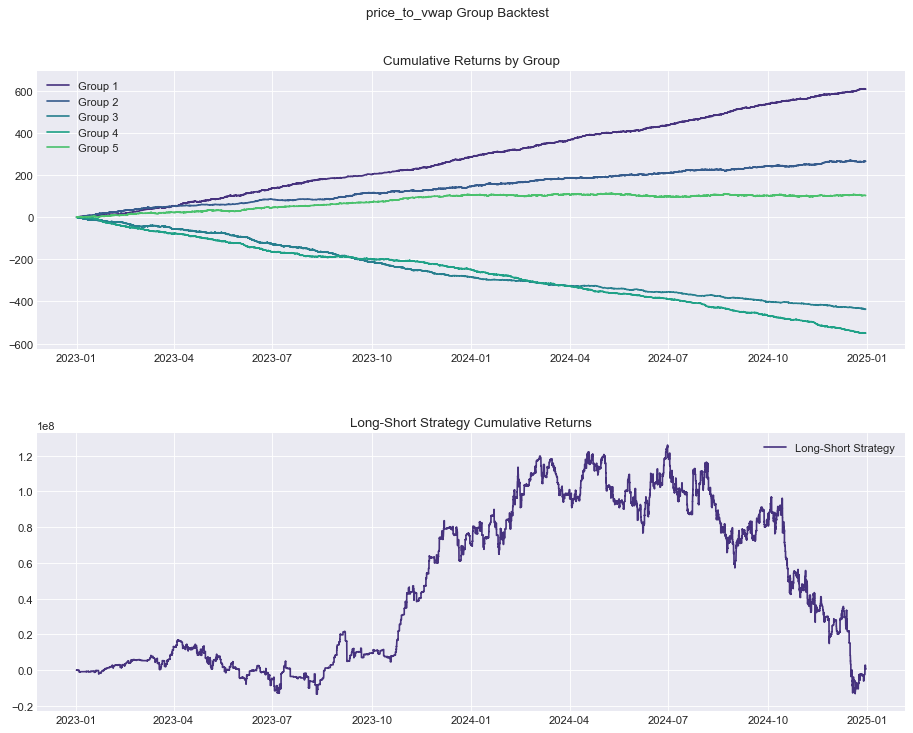

Long-Short Strategy Performance Metrics:
Annualized Return: 324581.43%
Annualized Volatility: 394099116.09%
Sharpe Ratio: 0.00

正在回測因子: momentum_24h
  開始分組回測...
注意：發現 134643 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695200.6377]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31514 個數據點
  組 2: 31513 個數據點
  組 3: 31514 個數據點
  組 4: 31513 個數據點
  組 5: 31514 個數據點
組 1 平均收益率：21348.2775
組 2 平均收益率：20530.8793
組 3 平均收益率：22234.6701
組 4 平均收益率：26571.9044
組 5 平均收益率：27068.4021
警告: 組 1 有 12332 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 12794 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13203 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 13698 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 14536 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 42526 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1665663.7929, 1695186.1294]
已裁剪 590 個極端多空收益率值 (1.0%)
多空策略年化收益率：166853927.10%
多空策略年化波動率：366845300.18%
多空策略Sharpe比率：0.45
  Sharpe比率: 0.45


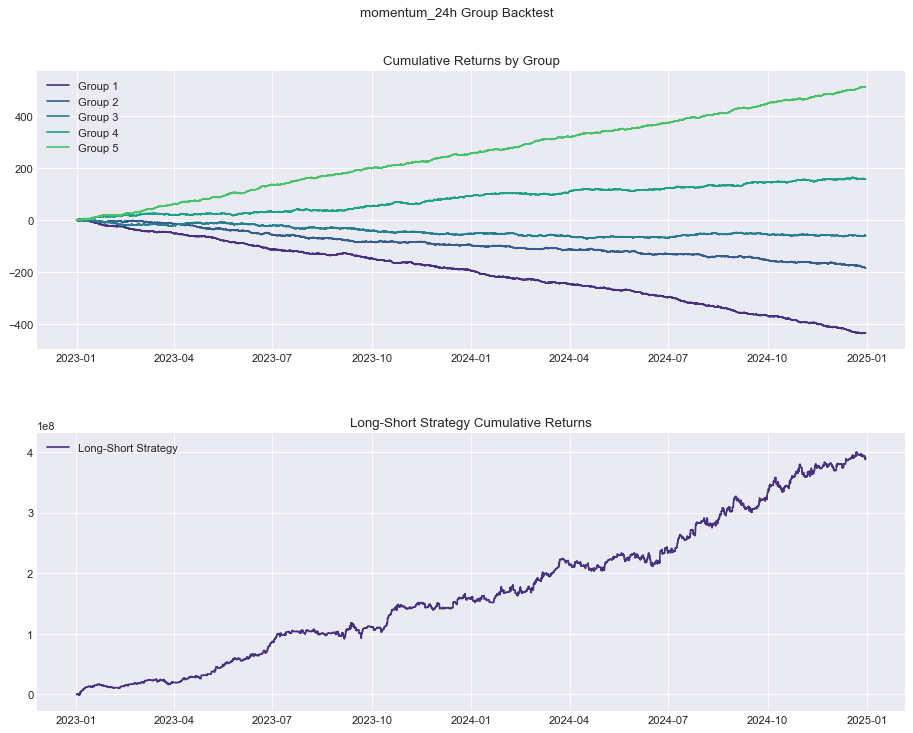

Long-Short Strategy Performance Metrics:
Annualized Return: 166853927.10%
Annualized Volatility: 366845300.18%
Sharpe Ratio: 0.45

正在回測因子: liquidity_risk
  開始分組回測...
注意：發現 134644 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695192.4601]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31514 個數據點
  組 2: 31514 個數據點
  組 3: 31513 個數據點
  組 4: 31514 個數據點
  組 5: 31514 個數據點
組 1 平均收益率：14049.0632
組 2 平均收益率：21586.8724
組 3 平均收益率：27693.3885
組 4 平均收益率：28651.6200
組 5 平均收益率：25772.3689
警告: 組 1 有 11883 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 12579 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13455 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 14170 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 14476 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 38710 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-668475.2431, 1694072.9693]
已裁剪 542 個極端多空收益率值 (1.0%)
多空策略年化收益率：396086814.39%
多空策略年化波動率：281848038.98%
多空策略Sharpe比率：1.41
  Sharpe比率: 1.41


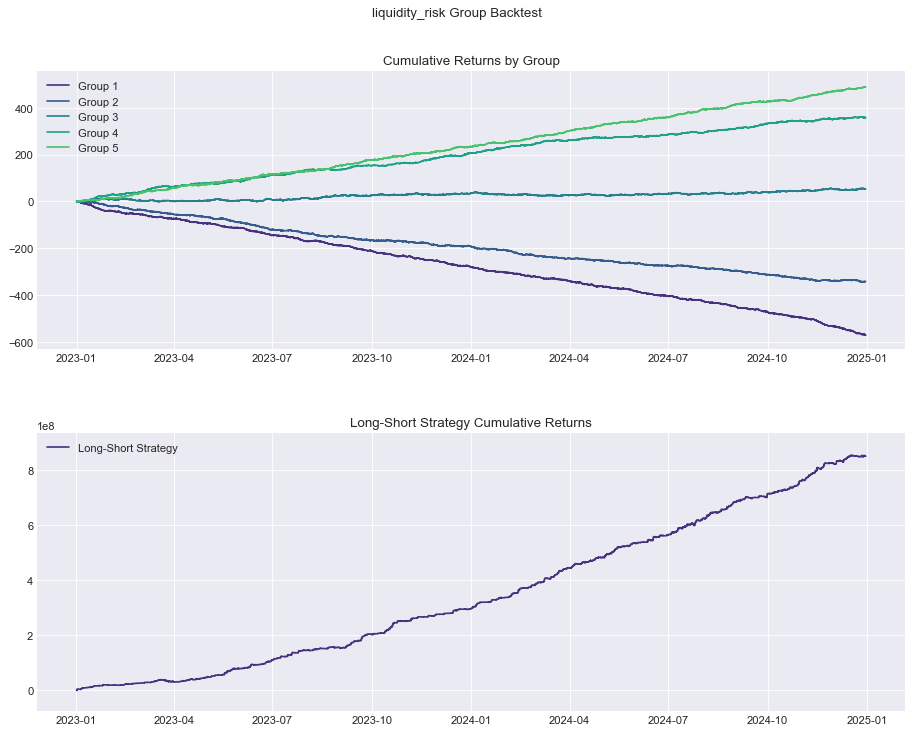

Long-Short Strategy Performance Metrics:
Annualized Return: 396086814.39%
Annualized Volatility: 281848038.98%
Sharpe Ratio: 1.41

正在回測因子: trade_size_change
  開始分組回測...
注意：發現 134644 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695192.4601]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31514 個數據點
  組 2: 31514 個數據點
  組 3: 31513 個數據點
  組 4: 31514 個數據點
  組 5: 31514 個數據點
組 1 平均收益率：25980.7876
組 2 平均收益率：28058.1140
組 3 平均收益率：23037.0814
組 4 平均收益率：24613.0734
組 5 平均收益率：16064.1089
警告: 組 1 有 14487 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 14180 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13118 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 12431 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 12347 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 35804 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1551087.4770, 1179938.5729]
已裁剪 496 個極端多空收益率值 (1.0%)
多空策略年化收益率：-216900835.88%
多空策略年化波動率：285792655.49%
多空策略Sharpe比率：-0.76
  Sharpe比率: -0.76


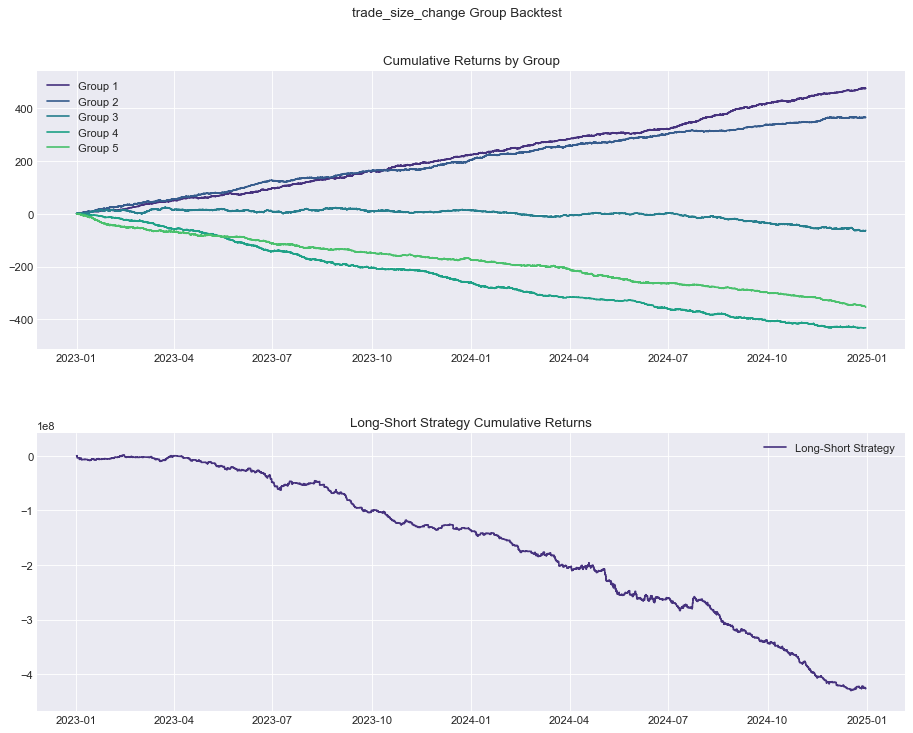

Long-Short Strategy Performance Metrics:
Annualized Return: -216900835.88%
Annualized Volatility: 285792655.49%
Sharpe Ratio: -0.76

正在回測因子: momentum_8h
  開始分組回測...
注意：發現 134659 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695069.7947]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31517 個數據點
  組 2: 31517 個數據點
  組 3: 31516 個數據點
  組 4: 31517 個數據點
  組 5: 31517 個數據點
組 1 平均收益率：20682.2015
組 2 平均收益率：20713.3029
組 3 平均收益率：24246.8106
組 4 平均收益率：25763.6298
組 5 平均收益率：26333.6086
警告: 組 1 有 12433 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 12903 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13125 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 13670 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 14439 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 44577 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1609866.5868, 1694042.2789]
已裁剪 616 個極端多空收益率值 (1.0%)
多空策略年化收益率：162915593.28%
多空策略年化波動率：353021416.98%
多空策略Sharpe比率：0.46
  Sharpe比率: 0.46


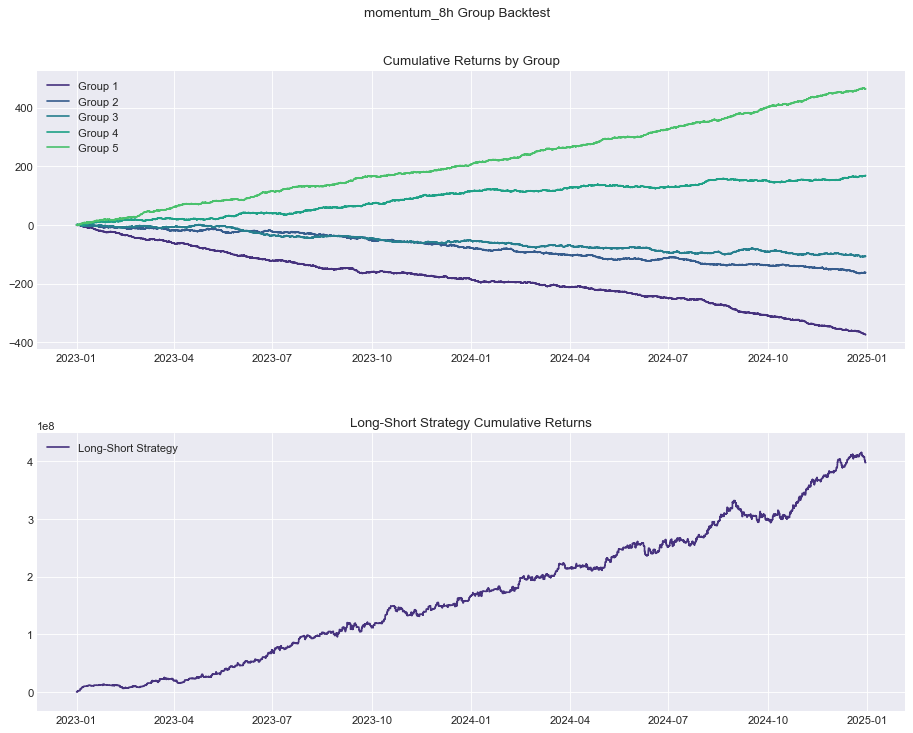

Long-Short Strategy Performance Metrics:
Annualized Return: 162915593.28%
Annualized Volatility: 353021416.98%
Sharpe Ratio: 0.46

正在回測因子: momentum_12h
  開始分組回測...
注意：發現 134655 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695102.5054]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31516 個數據點
  組 2: 31516 個數據點
  組 3: 31516 個數據點
  組 4: 31516 個數據點
  組 5: 31516 個數據點
組 1 平均收益率：19499.5469
組 2 平均收益率：23709.0881
組 3 平均收益率：23952.2275
組 4 平均收益率：24330.4018
組 5 平均收益率：26252.0718
警告: 組 1 有 12313 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 12984 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13069 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 13788 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 14414 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 41380 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1538718.7532, 1693744.5172]
已裁剪 574 個極端多空收益率值 (1.0%)
多空策略年化收益率：186384793.71%
多空策略年化波動率：346217399.98%
多空策略Sharpe比率：0.54
  Sharpe比率: 0.54


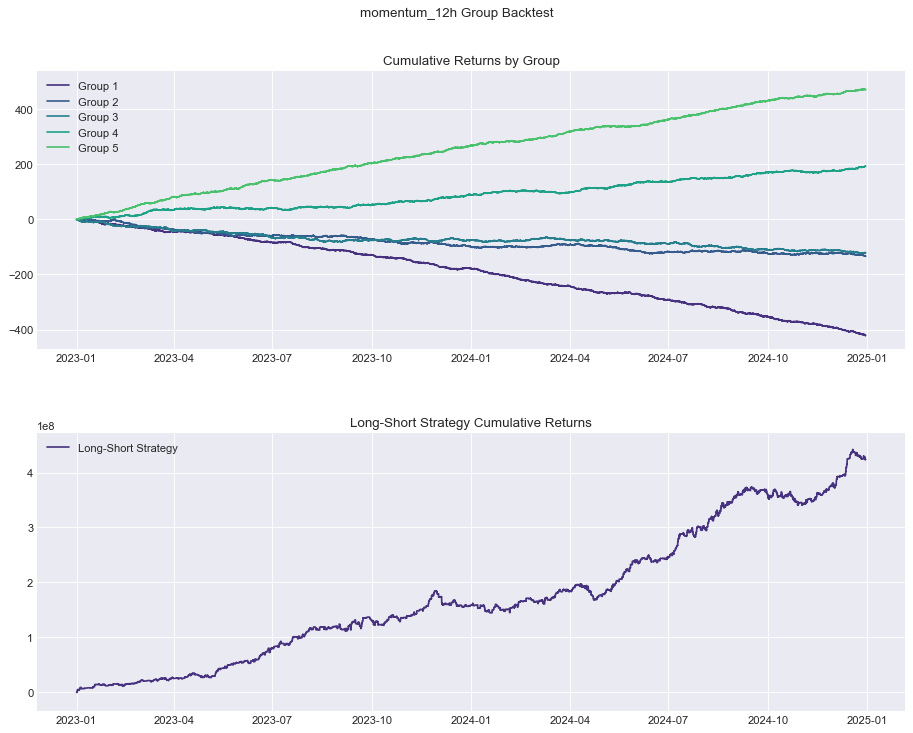

Long-Short Strategy Performance Metrics:
Annualized Return: 186384793.71%
Annualized Volatility: 346217399.98%
Sharpe Ratio: 0.54

正在回測因子: price_impact
  開始分組回測...
注意：發現 134644 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695192.4601]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31514 個數據點
  組 2: 31514 個數據點
  組 3: 31513 個數據點
  組 4: 31514 個數據點
  組 5: 31514 個數據點
組 1 平均收益率：17177.9965
組 2 平均收益率：22320.7594
組 3 平均收益率：26111.6110
組 4 平均收益率：26683.5890
組 5 平均收益率：25459.3069
警告: 組 1 有 12371 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 12393 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13494 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 13844 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 14461 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 39530 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1361938.7601, 1693844.8930]
已裁剪 548 個極端多空收益率值 (1.0%)
多空策略年化收益率：244830424.48%
多空策略年化波動率：316516111.75%
多空策略Sharpe比率：0.77
  Sharpe比率: 0.77


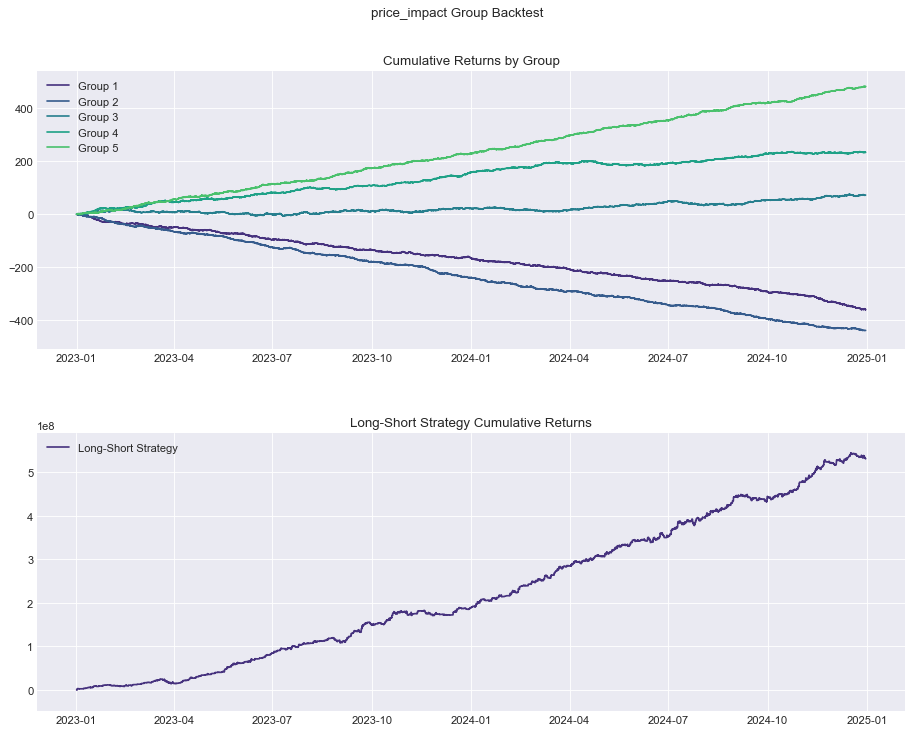

Long-Short Strategy Performance Metrics:
Annualized Return: 244830424.48%
Annualized Volatility: 316516111.75%
Sharpe Ratio: 0.77

正在回測因子: macd_line
  開始分組回測...
注意：發現 134667 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695004.3731]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31519 個數據點
  組 2: 31518 個數據點
  組 3: 31518 個數據點
  組 4: 31518 個數據點
  組 5: 31519 個數據點
組 1 平均收益率：25864.9651
組 2 平均收益率：20619.0006
組 3 平均收益率：19778.5866
組 4 平均收益率：23382.3105
組 5 平均收益率：28089.0132
警告: 組 1 有 11638 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 12065 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13488 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 14348 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 15035 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 33674 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1694973.8258, 1695005.0131]
已裁剪 468 個極端多空收益率值 (1.0%)
多空策略年化收益率：120939079.10%
多空策略年化波動率：408260807.97%
多空策略Sharpe比率：0.30
  Sharpe比率: 0.30


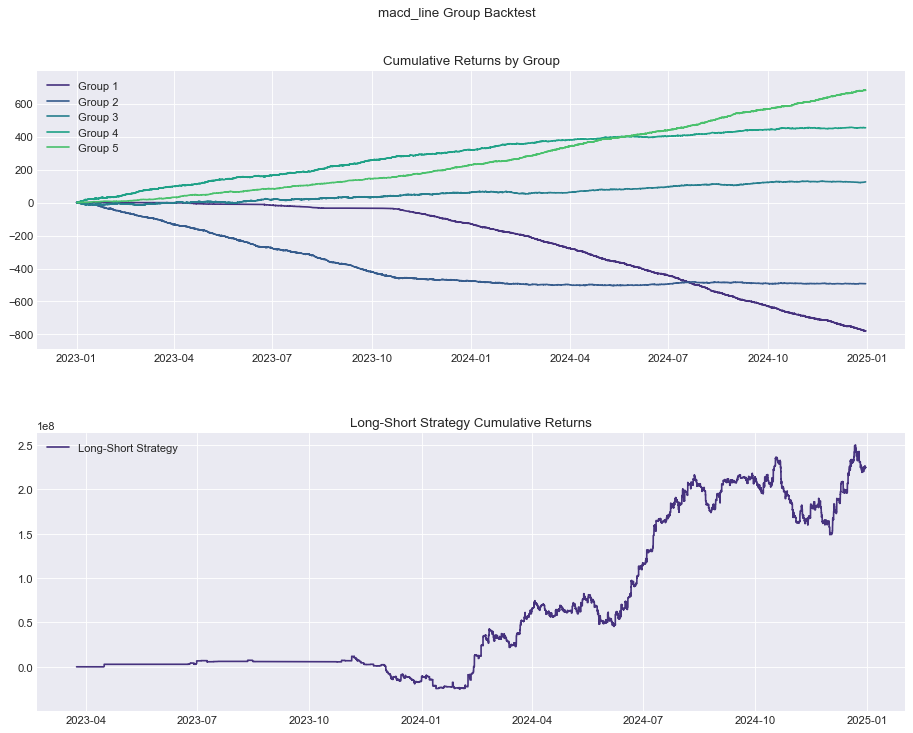

Long-Short Strategy Performance Metrics:
Annualized Return: 120939079.10%
Annualized Volatility: 408260807.97%
Sharpe Ratio: 0.30

正在回測因子: hl_volume_position
  開始分組回測...
注意：發現 134625 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695380.5470]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31510 個數據點
  組 2: 31509 個數據點
  組 3: 31509 個數據點
  組 4: 31509 個數據點
  組 5: 31509 個數據點
組 1 平均收益率：20595.9344
組 2 平均收益率：23939.1793
組 3 平均收益率：27427.8156
組 4 平均收益率：27080.4442
組 5 平均收益率：18699.8827
警告: 組 1 有 13291 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 13532 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13928 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 13366 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 12437 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 33557 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1357633.7912, 1481112.5824]
已裁剪 476 個極端多空收益率值 (1.0%)
多空策略年化收益率：44199566.66%
多空策略年化波動率：282134337.41%
多空策略Sharpe比率：0.16
  Sharpe比率: 0.16


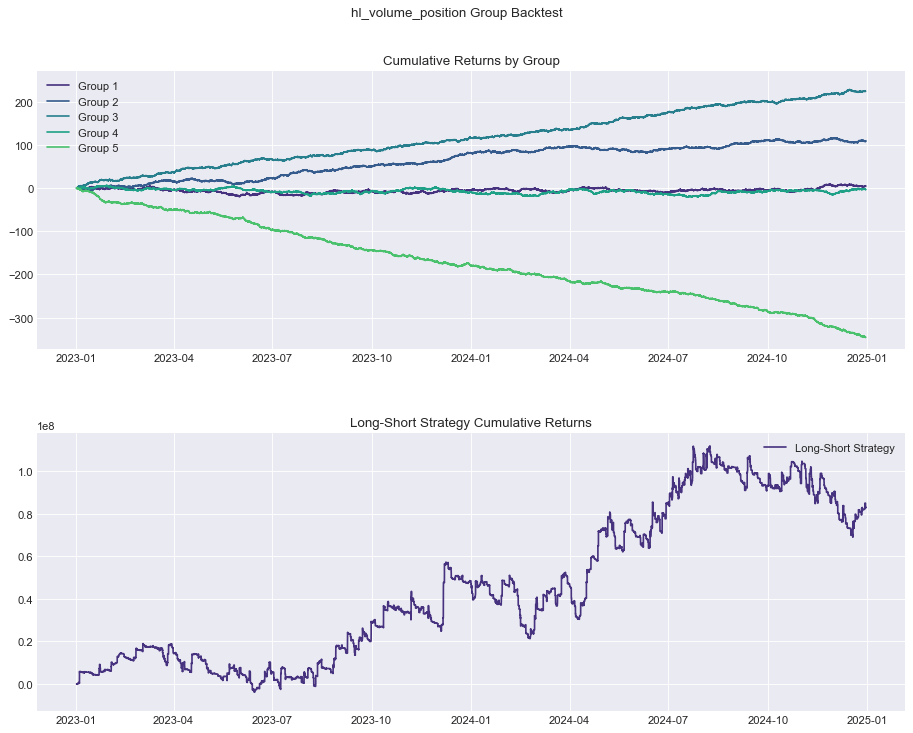

Long-Short Strategy Performance Metrics:
Annualized Return: 44199566.66%
Annualized Volatility: 282134337.41%
Sharpe Ratio: 0.16

正在回測因子: macd_histogram
  開始分組回測...
注意：發現 134667 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695004.3731]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31519 個數據點
  組 2: 31518 個數據點
  組 3: 31518 個數據點
  組 4: 31518 個數據點
  組 5: 31519 個數據點
組 1 平均收益率：28793.8820
組 2 平均收益率：20857.8262
組 3 平均收益率：18292.3501
組 4 平均收益率：21830.9001
組 5 平均收益率：27958.8288
警告: 組 1 有 12441 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 12292 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 12695 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 14175 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 14971 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 38710 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1695003.4723, 1695004.3762]
已裁剪 532 個極端多空收益率值 (1.0%)
多空策略年化收益率：34129262.87%
多空策略年化波動率：423548940.72%
多空策略Sharpe比率：0.08
  Sharpe比率: 0.08


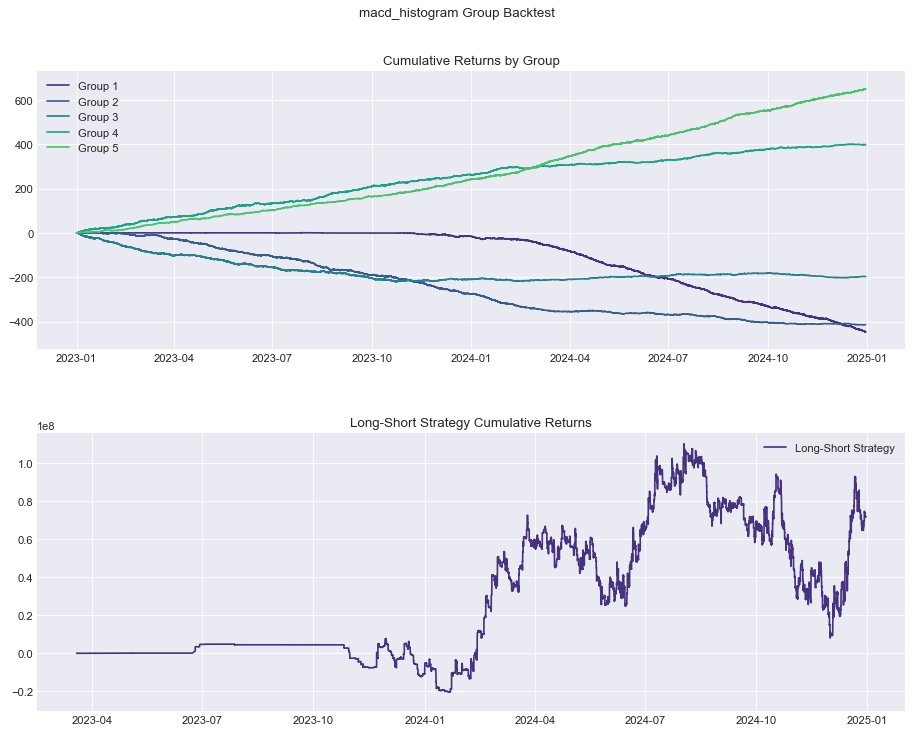

Long-Short Strategy Performance Metrics:
Annualized Return: 34129262.87%
Annualized Volatility: 423548940.72%
Sharpe Ratio: 0.08

正在回測因子: vpin
  開始分組回測...
注意：發現 134634 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695282.4147]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31512 個數據點
  組 2: 31511 個數據點
  組 3: 31512 個數據點
  組 4: 31511 個數據點
  組 5: 31512 個數據點
組 1 平均收益率：23622.2557
組 2 平均收益率：23796.7274
組 3 平均收益率：23566.2387
組 4 平均收益率：24983.5992
組 5 平均收益率：21794.8294
警告: 組 1 有 13453 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 13324 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13216 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 13352 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 13214 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 8072 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1695282.4183, 1694665.3895]
已裁剪 110 個極端多空收益率值 (1.0%)
多空策略年化收益率：-278119022.41%
多空策略年化波動率：424196921.50%
多空策略Sharpe比率：-0.66
  Sharpe比率: -0.66


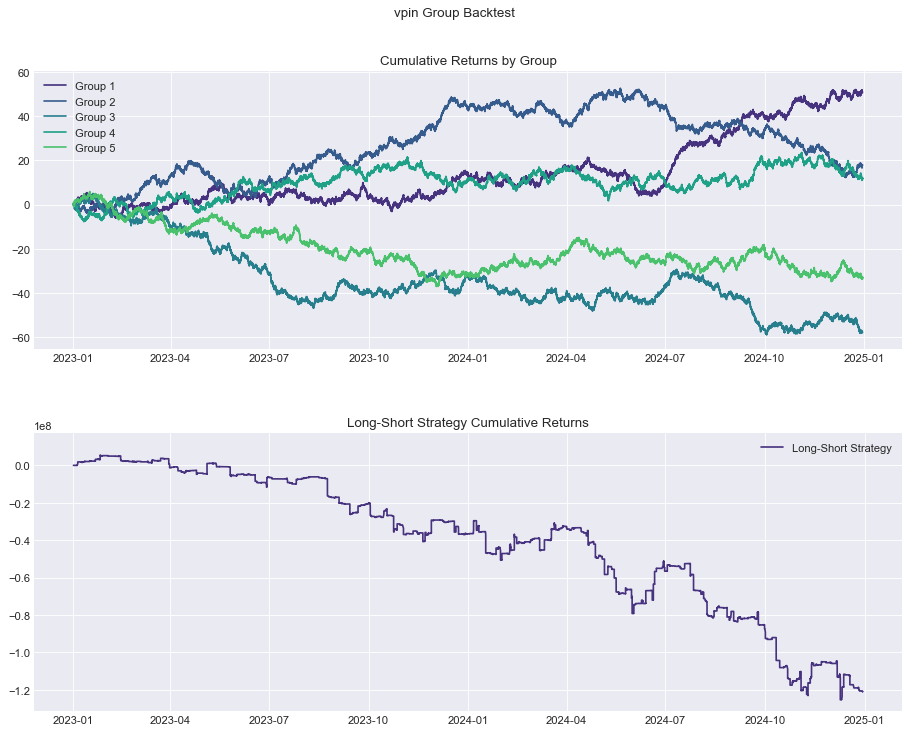

Long-Short Strategy Performance Metrics:
Annualized Return: -278119022.41%
Annualized Volatility: 424196921.50%
Sharpe Ratio: -0.66

正在回測因子: volume_12h
  開始分組回測...
注意：發現 134655 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695102.5054]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31516 個數據點
  組 2: 31516 個數據點
  組 3: 31516 個數據點
  組 4: 31516 個數據點
  組 5: 31516 個數據點
組 1 平均收益率：26354.6476
組 2 平均收益率：23990.7752
組 3 平均收益率：23851.5743
組 4 平均收益率：24280.5170
組 5 平均收益率：19265.8220
警告: 組 1 有 14247 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 13755 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13287 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 12955 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 12324 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 40911 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1688576.3754, 1432130.3130]
已裁剪 568 個極端多空收益率值 (1.0%)
多空策略年化收益率：-211129766.52%
多空策略年化波動率：330984532.90%
多空策略Sharpe比率：-0.64
  Sharpe比率: -0.64


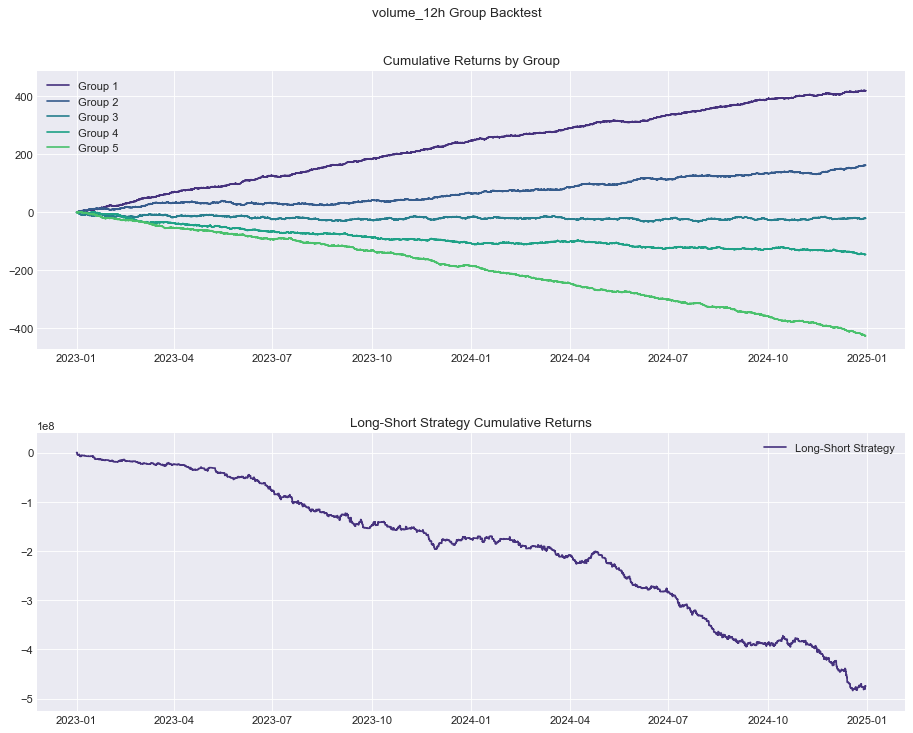

Long-Short Strategy Performance Metrics:
Annualized Return: -211129766.52%
Annualized Volatility: 330984532.90%
Sharpe Ratio: -0.64

正在回測因子: volume_8h
  開始分組回測...
注意：發現 134659 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695069.7947]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31517 個數據點
  組 2: 31517 個數據點
  組 3: 31516 個數據點
  組 4: 31517 個數據點
  組 5: 31517 個數據點
組 1 平均收益率：25936.1000
組 2 平均收益率：25162.0758
組 3 平均收益率：23979.7705
組 4 平均收益率：22062.0835
組 5 平均收益率：20599.5152
警告: 組 1 有 14293 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 13645 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13311 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 12915 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 12406 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 44040 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1687945.3888, 1578893.3805]
已裁剪 612 個極端多空收益率值 (1.0%)
多空策略年化收益率：-126040597.44%
多空策略年化波動率：345576206.96%
多空策略Sharpe比率：-0.36
  Sharpe比率: -0.36


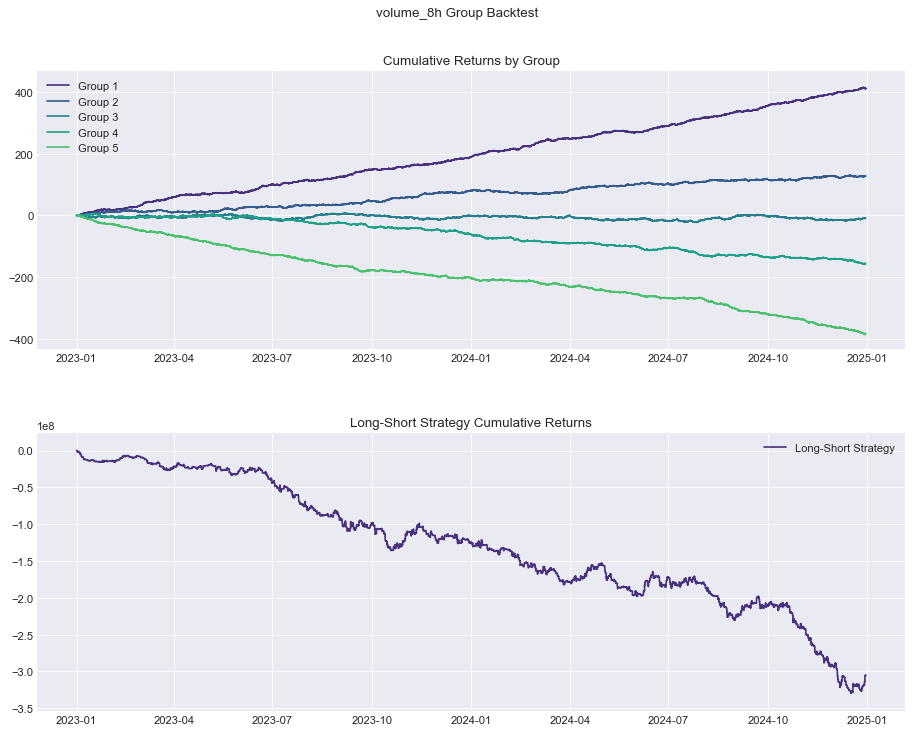

Long-Short Strategy Performance Metrics:
Annualized Return: -126040597.44%
Annualized Volatility: 345576206.96%
Sharpe Ratio: -0.36

正在回測因子: volume_24h
  開始分組回測...
注意：發現 134643 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695200.6377]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31514 個數據點
  組 2: 31513 個數據點
  組 3: 31514 個數據點
  組 4: 31513 個數據點
  組 5: 31514 個數據點
組 1 平均收益率：27646.3469
組 2 平均收益率：25331.2975
組 3 平均收益率：22015.7641
組 4 平均收益率：21355.1548
組 5 平均收益率：21405.5568
警告: 組 1 有 14378 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 13729 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13238 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 12834 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 12384 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 41876 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1695165.2698, 1570474.0422]
已裁剪 580 個極端多空收益率值 (1.0%)
多空策略年化收益率：-178744977.72%
多空策略年化波動率：357794319.03%
多空策略Sharpe比率：-0.50
  Sharpe比率: -0.50


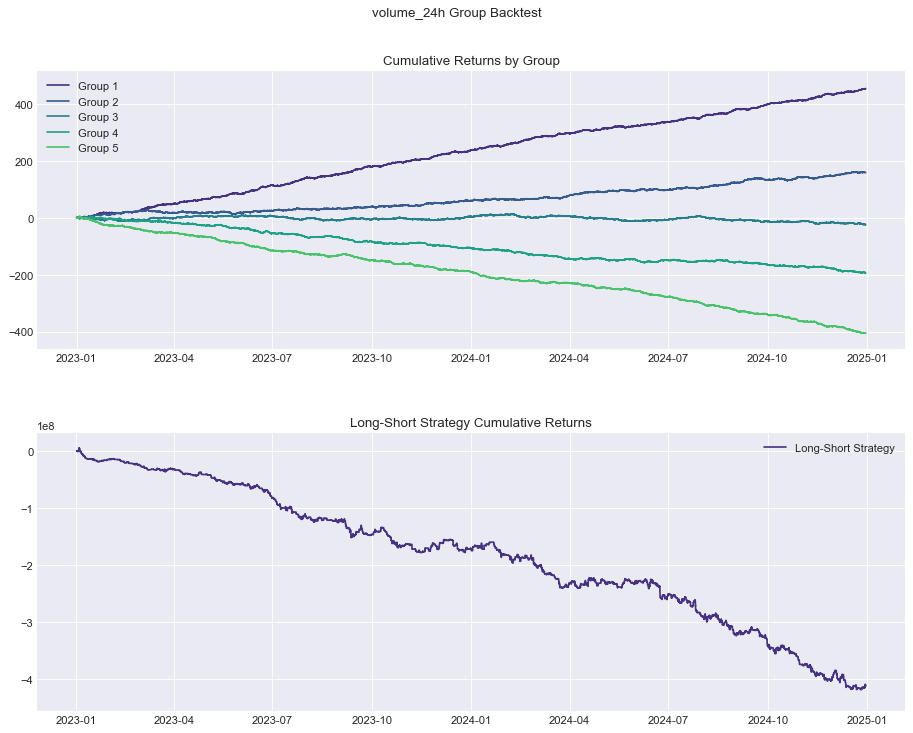

Long-Short Strategy Performance Metrics:
Annualized Return: -178744977.72%
Annualized Volatility: 357794319.03%
Sharpe Ratio: -0.50

正在回測因子: macd_signal
  開始分組回測...
注意：發現 134667 個極端收益率 (>50% 或 <-50%)
警告：極端收益率過多（85.5%），將影響結果可靠性
收益率Winsorization範圍：[-1.0000, 1695004.3731]
已裁剪 1576 個極端收益率值 (1.0%)
使用分位數分組成功
各組數據點數量：
  組 1: 31519 個數據點
  組 2: 31518 個數據點
  組 3: 31518 個數據點
  組 4: 31518 個數據點
  組 5: 31519 個數據點
組 1 平均收益率：22403.4034
組 2 平均收益率：21134.4658
組 3 平均收益率：21599.2871
組 4 平均收益率：22126.9911
組 5 平均收益率：30469.7629
警告: 組 1 有 11197 個極端收益率 (>100% 或 <-100%)
警告: 組 2 有 12674 個極端收益率 (>100% 或 <-100%)
警告: 組 3 有 13639 個極端收益率 (>100% 或 <-100%)
警告: 組 4 有 14202 個極端收益率 (>100% 或 <-100%)
警告: 組 5 有 14862 個極端收益率 (>100% 或 <-100%)
警告：多空策略中有 9539 個極端收益率差值 (>100% 或 <-100%)
多空策略收益率Winsorization範圍：[-1195476.5712, 1695005.3667]
已裁剪 140 個極端多空收益率值 (1.0%)
多空策略年化收益率：624378266.44%
多空策略年化波動率：371575737.76%
多空策略Sharpe比率：1.68
  Sharpe比率: 1.68


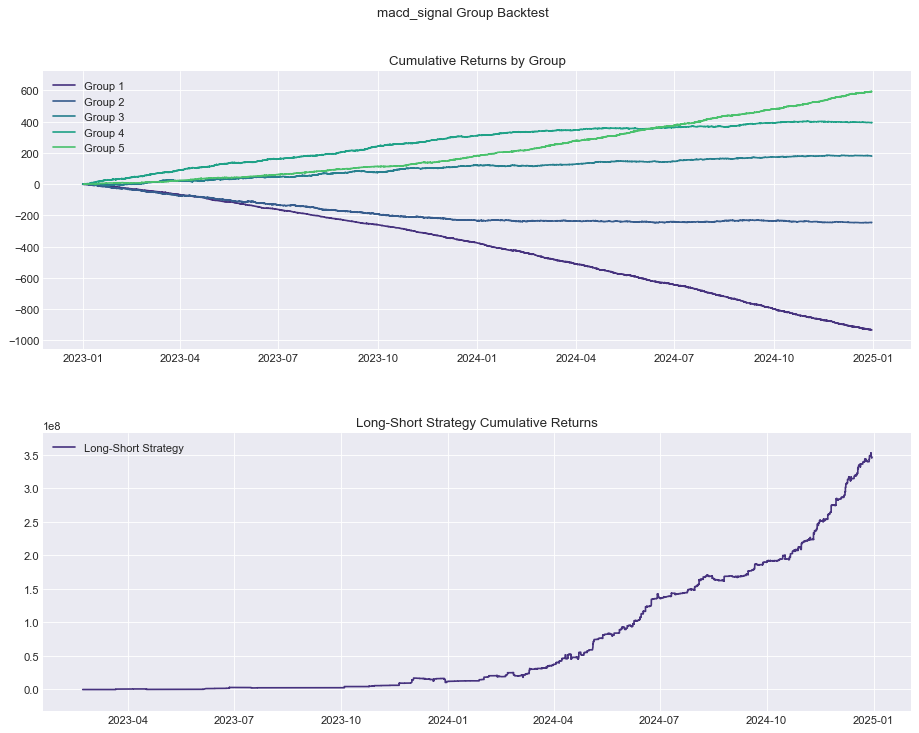

Long-Short Strategy Performance Metrics:
Annualized Return: 624378266.44%
Annualized Volatility: 371575737.76%
Sharpe Ratio: 1.68

成功完成 15 個因子的回測

評估最佳因子:
  price_to_vwap: Sharpe比率 = 0.00
  momentum_24h: Sharpe比率 = 0.45
  liquidity_risk: Sharpe比率 = 1.41
  trade_size_change: Sharpe比率 = -0.76
  momentum_8h: Sharpe比率 = 0.46
  momentum_12h: Sharpe比率 = 0.54
  price_impact: Sharpe比率 = 0.77
  macd_line: Sharpe比率 = 0.30
  hl_volume_position: Sharpe比率 = 0.16
  macd_histogram: Sharpe比率 = 0.08
  vpin: Sharpe比率 = -0.66
  volume_12h: Sharpe比率 = -0.64
  volume_8h: Sharpe比率 = -0.36
  volume_24h: Sharpe比率 = -0.50
  macd_signal: Sharpe比率 = 1.68

Best factor based on Sharpe ratio: macd_signal (Sharpe: 1.68)


In [27]:
# 根據因子值分組並回測
def factor_portfolio_backtest(df, factor, n_groups=5, target_col='future_return_24', min_periods=60):  # min_period : 最小數據集 
    
    # 確保索引對齊
    common_idx = df.index.intersection(factor.index)
    if len(common_idx) < min_periods:
        print(f"警告：有效數據點不足（{len(common_idx)} < {min_periods}）")
        return None
    
    factor = factor.loc[common_idx]
    
    # 檢查目標列是否存在
    if target_col not in df.columns:
        print(f"警告：目標列 {target_col} 不存在")
        target_cols = [col for col in df.columns if 'future_return' in col]
        if target_cols:
            target_col = target_cols[0]
            print(f"使用替代目標列：{target_col}")
        else:
            print("無法找到任何未來收益率列")
            return None
            
    returns = df.loc[common_idx, target_col]
    
    # 檢查收益率數據
    if returns.isna().all():
        print("警告：收益率數據全為NA")
        return None
        
    if returns.empty:
        print("警告：收益率數據為空")
        return None
    
    # 移除缺失值
    valid_data = pd.concat([factor, returns], axis=1).dropna()
    if len(valid_data) < min_periods:
        print(f"警告：去除缺失值後數據不足（{len(valid_data)} < {min_periods}）")
        return None
        
    factor = valid_data.iloc[:, 0]
    returns = valid_data.iloc[:, 1]
    
    # 檢查收益率極端值
    extreme_returns = returns[returns.abs() > 0.5]  # 50%以上的收益率可能有問題
    if len(extreme_returns) > 0:
        print(f"注意：發現 {len(extreme_returns)} 個極端收益率 (>50% 或 <-50%)")
        if len(extreme_returns) > len(returns) * 0.05:  # 如果超過5%的數據是極端值
            print(f"警告：極端收益率過多（{len(extreme_returns)/len(returns)*100:.1f}%），將影響結果可靠性")
    
    # 處理極端收益率，使用Winsorization方法將極端值裁剪到合理範圍
    # 將超過99.5%和低於0.5%的收益率調整到這些百分位數值
    if returns.size > 0:
        lower_bound = np.percentile(returns, 0.5)
        upper_bound = np.percentile(returns, 99.5)
        print(f"收益率Winsorization範圍：[{lower_bound:.4f}, {upper_bound:.4f}]")
        original_returns = returns.copy()
        returns = returns.clip(lower=lower_bound, upper=upper_bound)
        # 檢查裁剪了多少數據
        clipped_count = (original_returns != returns).sum()
        if clipped_count > 0:
            print(f"已裁剪 {clipped_count} 個極端收益率值 ({clipped_count/len(returns)*100:.1f}%)")
    
    # 再次檢查因子值分布
    if factor.nunique() < n_groups:
        print(f"警告：因子唯一值數量 ({factor.nunique()}) 少於分組數量 ({n_groups})")
        n_groups = min(factor.nunique(), n_groups)
        print(f"調整分組數量為 {n_groups}")
    
    # 按因子值分組
    labels = list(range(1, n_groups + 1))
    try:
        groups = pd.qcut(factor, n_groups, labels=labels)
        print("使用分位數分組成功")
    except ValueError as e:
        print(f"分位數分組出錯（可能是重複值）：{e}")
        # 處理重複值問題
        try:
            groups = pd.qcut(factor, n_groups, labels=labels, duplicates='drop')
            print("使用duplicates='drop'成功分組")
        except Exception as e2:
            print(f"處理重複值後分組仍失敗：{e2}")
            # 如果仍然失敗，使用等距分組
            try:
                factor_min, factor_max = factor.min(), factor.max()
                if factor_min == factor_max:
                    print("警告：因子最大值等於最小值，無法分組")
                    return None
                bins = np.linspace(factor_min, factor_max, n_groups + 1)
                groups = pd.cut(factor, bins=bins, labels=labels, include_lowest=True)
                print("使用等距分組成功")
            except Exception as e3:
                print(f"所有分組方法都失敗：{e3}")
                return None
    
    # 計算各組數量
    group_counts = groups.value_counts().sort_index()
    print("各組數據點數量：")
    for group, count in group_counts.items():
        print(f"  組 {group}: {count} 個數據點")
    
    # 檢查是否存在為空的組
    if group_counts.min() == 0:
        print("警告：存在沒有數據的組")
    
    # 計算各組收益率
    group_returns = {}
    for group in labels:
        group_mask = (groups == group)
        # 確保該組有數據
        if any(group_mask):
            group_returns[group] = returns[group_mask]
            mean_return = group_returns[group].mean()
            print(f"組 {group} 平均收益率：{mean_return:.4f}")
        else:
            # 如果沒有數據，添加空序列
            group_returns[group] = pd.Series(dtype=float)
            print(f"組 {group} 沒有數據")
    
    # 檢查每個組是否有數據
    empty_groups = [group for group, ret in group_returns.items() if ret.empty]
    if empty_groups:
        print(f"警告: 組 {', '.join(map(str, empty_groups))} 沒有數據")
        if 1 in empty_groups or n_groups in empty_groups:
            # 如果最高組或最低組沒有數據，無法計算多空策略
            print("最高組或最低組沒有數據，無法計算多空策略")
            return None
    
    # 檢查各組是否有足夠樣本
    insufficient_groups = [group for group, ret in group_returns.items() if len(ret) < min_periods/n_groups]
    if insufficient_groups:
        print(f"警告: 組 {', '.join(map(str, insufficient_groups))} 樣本數不足")
    
    # 計算各組累積收益率
    cumulative_returns = {}
    for group, ret in group_returns.items():
        if not ret.empty:
            # 安全地計算累積收益率
            try:
                # 先檢查是否有極端值
                if (ret.abs() > 1).any():
                    extreme_count = (ret.abs() > 1).sum()
                    print(f"警告: 組 {group} 有 {extreme_count} 個極端收益率 (>100% 或 <-100%)")
                    # 對該組重新進行極端值處理
                    ret = ret.clip(lower=-0.2, upper=0.2)  # 更保守地裁剪到±20%
                
                # 計算累積收益率 - 改用簡單加總而非複利
                cum_ret = ret.cumsum()
                
                # 檢查累積收益率是否有問題
                if np.isinf(cum_ret).any() or cum_ret.isna().any():
                    inf_count = np.isinf(cum_ret).sum()
                    na_count = cum_ret.isna().sum()
                    print(f"警告: 組 {group} 的累積收益率包含 {inf_count} 個無限值和 {na_count} 個NA值")
                    
                    # 嘗試替代方法：微幅調整收益率再計算
                    adjusted_ret = ret.clip(lower=-0.1, upper=0.1)  # 更嚴格的限制
                    cum_ret = adjusted_ret.cumsum()
                    print(f"嘗試使用更嚴格限制的收益率重新計算")
                
                # 再次檢查
                if np.isinf(cum_ret).any() or cum_ret.isna().any():
                    print(f"警告: 組 {group} 的累積收益率仍有問題，使用簡單增長率")
                    # 使用非常保守的方法：每個收益率限制在1%範圍內
                    safe_ret = ret.clip(lower=-0.01, upper=0.01)
                    cum_ret = safe_ret.cumsum()
                
                cumulative_returns[group] = cum_ret
            except Exception as e:
                print(f"警告: 計算組 {group} 的累積收益率時出錯: {e}")
                # 添加一個空序列
                cumulative_returns[group] = pd.Series(dtype=float)
        else:
            cumulative_returns[group] = pd.Series(dtype=float)
    
    # 檢查是否可以計算多空策略
    if 1 not in group_returns or n_groups not in group_returns or group_returns[1].empty or group_returns[n_groups].empty:
        print("無法計算多空策略：缺少最高組或最低組的數據")
        return None
    
    # 計算多空策略收益率時避免時間索引不一致
    highest_group = group_returns[n_groups].copy()
    lowest_group = group_returns[1].copy()
    
    # 確保兩個組的時間索引一致
    common_index = highest_group.index.intersection(lowest_group.index)
    if len(common_index) < min_periods:
        print(f"警告：最高組和最低組的共同時間點不足（{len(common_index)} < {min_periods}）")
        return None
    
    highest_group = highest_group.loc[common_index]
    lowest_group = lowest_group.loc[common_index]
    
    # 構建 Long-Short 策略 (最高分組 - 最低分組)
    ls_returns = highest_group - lowest_group
    
    # 檢查多空策略收益率
    ls_extreme = (ls_returns.abs() > 1).sum()
    if ls_extreme > 0:
        print(f"警告：多空策略中有 {ls_extreme} 個極端收益率差值 (>100% 或 <-100%)")
    
    # 處理多空策略中的極端值
    if ls_returns.size > 0:
        ls_lower_bound = np.percentile(ls_returns, 0.5)
        ls_upper_bound = np.percentile(ls_returns, 99.5)
        print(f"多空策略收益率Winsorization範圍：[{ls_lower_bound:.4f}, {ls_upper_bound:.4f}]")
        original_ls = ls_returns.copy()
        ls_returns = ls_returns.clip(lower=ls_lower_bound, upper=ls_upper_bound)
        # 檢查裁剪了多少數據
        ls_clipped_count = (original_ls != ls_returns).sum()
        if ls_clipped_count > 0:
            print(f"已裁剪 {ls_clipped_count} 個極端多空收益率值 ({ls_clipped_count/len(ls_returns)*100:.1f}%)")
    
    # 計算策略表現指標
    annualized_return = ls_returns.mean() * 252  # 假設數據為日頻
    annualized_vol = ls_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    print(f"多空策略年化收益率：{annualized_return:.2%}")
    print(f"多空策略年化波動率：{annualized_vol:.2%}")
    print(f"多空策略Sharpe比率：{sharpe_ratio:.2f}")
    
    # 計算最大回撤 - 使用累加而非複利

    # 直接使用簡單累加計算累積收益率，避免極端值問題
    ls_cum_returns = ls_returns.cumsum()
    
    # 檢查累積收益率是否有問題
    if np.isinf(ls_cum_returns).any() or ls_cum_returns.isna().any():
        inf_count = np.isinf(ls_cum_returns).sum()
        na_count = ls_cum_returns.isna().sum()
        print(f"警告: 多空策略累積收益率包含 {inf_count} 個無限值和 {na_count} 個NA值")
        
        # 嘗試更保守的方法
        ls_returns_safe = ls_returns.clip(lower=-0.1, upper=0.1)
        ls_cum_returns = ls_returns_safe.cumsum()
        print("使用更嚴格限制的收益率重新計算多空策略累積收益率")
        
        # 再次檢查
        if np.isinf(ls_cum_returns).any() or ls_cum_returns.isna().any():
            print("警告：多空策略累積收益率仍有問題，使用更保守的方法")
            ls_returns_safer = ls_returns.clip(lower=-0.01, upper=0.01)  # 更極端的限制
            ls_cum_returns = ls_returns_safer.cumsum()
    
        
    # 返回結果
    return {
        'group_returns': group_returns,
        'cumulative_returns': cumulative_returns,
        'ls_returns': ls_returns,
        'ls_cum_returns': ls_cum_returns,
        'annualized_return': annualized_return,
        'annualized_vol': annualized_vol,
        'sharpe_ratio': sharpe_ratio
    }


# 可視化分組回測結果
def plot_group_backtest(backtest_result, title='Factor Group Backtest'):
    """繪製分組回測結果"""
    if backtest_result is None:
        print("警告: 回測結果為空，無法繪圖")
        return
    
    # 檢查累積收益率是否存在
    if 'cumulative_returns' not in backtest_result or not backtest_result['cumulative_returns']:
        print("警告: 回測結果中缺少累積收益率數據")
        return
        
    if 'ls_cum_returns' not in backtest_result or backtest_result['ls_cum_returns'] is None:
        print("警告: 回測結果中缺少多空策略累積收益率數據")
        return
    
    # 檢查是否有足夠的組別數據可以繪圖
    valid_groups = []
    processed_cum_returns = {}
    
    # 處理各組的累積收益率
    for group, cum_ret in backtest_result['cumulative_returns'].items():
        # 檢查該組是否有數據
        if cum_ret is None or len(cum_ret) == 0:
            print(f"警告: 組 {group} 沒有累積收益率數據")
            continue
            
        # 檢查該組是否有異常值
        if cum_ret.isna().any():
            print(f"警告: 組 {group} 的累積收益率包含 {cum_ret.isna().sum()} 個缺失值")
        
        if np.isinf(cum_ret).any():
            print(f"警告: 組 {group} 的累積收益率包含 {np.isinf(cum_ret).sum()} 個無限值")
        
        # 如果該組有問題，嘗試修復
        if cum_ret.isna().any() or np.isinf(cum_ret).any():
            # 使用收益率的簡單累加而非複利來重新計算
            try:
                # 獲取原始收益率
                raw_returns = backtest_result['group_returns'][group]
                # 如果異常值太多，限制其範圍
                processed_returns = raw_returns.clip(lower=-0.1, upper=0.1)  # 限制在±10%範圍內
                # 使用簡單累加
                fixed_cum_ret = processed_returns.cumsum()
                processed_cum_returns[group] = fixed_cum_ret
                valid_groups.append(group)
                print(f"已修復組 {group} 的累積收益率數據")
            except Exception as e:
                print(f"無法修復組 {group} 的數據: {e}")
                continue
        else:
            # 若數據良好，直接使用
            processed_cum_returns[group] = cum_ret
            valid_groups.append(group)
    
    # 處理多空策略累積收益率
    ls_cum_returns = backtest_result['ls_cum_returns']
    ls_valid = True
    
    if ls_cum_returns.isna().any() or np.isinf(ls_cum_returns).any():
        print(f"警告: Long-Short 策略的累積收益率包含異常值，嘗試修復")
        try:
            # 獲取原始多空收益率
            ls_returns = backtest_result['ls_returns']
            # 限制範圍
            processed_ls_returns = ls_returns.clip(lower=-0.1, upper=0.1)
            # 使用簡單累加
            ls_cum_returns = processed_ls_returns.cumsum()
            print("已修復多空策略的累積收益率數據")
        except Exception as e:
            print(f"無法修復多空策略數據: {e}")
            ls_valid = False
    
    # 如果沒有有效的組別數據和多空策略數據無效，提前返回
    if not valid_groups and not ls_valid:
        print("警告: 所有組的累積收益率都存在問題，已跳過繪圖")
        # 仍然顯示策略指標
        if 'sharpe_ratio' in backtest_result and 'annualized_return' in backtest_result:
            print(f"Long-Short Strategy Performance Metrics:")
            print(f"Annualized Return: {backtest_result['annualized_return']:.2%}")
            print(f"Annualized Volatility: {backtest_result['annualized_vol']:.2%}")
            print(f"Sharpe Ratio: {backtest_result['sharpe_ratio']:.2f}")
            
        return
    
    # 創建繪圖區域
    try:
        # 根據有效數據決定繪圖內容
        if ls_valid and len(valid_groups) > 0:
            fig, axes = plt.subplots(2, 1, figsize=(14, 10))
            plot_top = True
            plot_bottom = True
        elif len(valid_groups) > 0:
            fig, axes = plt.subplots(1, 1, figsize=(14, 5))
            axes = [axes]  # 轉換為列表以保持一致性
            plot_top = True
            plot_bottom = False
        elif ls_valid:
            fig, axes = plt.subplots(1, 1, figsize=(14, 5))
            axes = [axes]  # 轉換為列表以保持一致性
            plot_top = False
            plot_bottom = True
        else:
            # 如果沒有數據可以繪圖，返回
            print("警告: 沒有有效數據可以繪圖")
            return
        
        # 繪製各組累積收益率
        if plot_top:
            ax_idx = 0
            for group in valid_groups:
                cum_ret = processed_cum_returns[group]
                axes[ax_idx].plot(cum_ret.index, cum_ret.values, label=f'Group {group}')
            
            axes[ax_idx].set_title('Cumulative Returns by Group')
            axes[ax_idx].legend()
            axes[ax_idx].grid(True)
            
            # 設置Y軸顯示範圍，避免極端值干擾圖形
            y_values = np.concatenate([cum_ret.values for cum_ret in processed_cum_returns.values() if len(cum_ret) > 0])
            if len(y_values) > 0:
                y_values = y_values[~np.isnan(y_values) & ~np.isinf(y_values)]  # 移除NaN和無限值
                if len(y_values) > 0:
                    y_min, y_max = np.percentile(y_values, [1, 99])  # 使用1%和99%分位數
                    margin = (y_max - y_min) * 0.1  # 增加10%邊距
                    axes[ax_idx].set_ylim(y_min - margin, y_max + margin)
        
        # 繪製多空策略累積收益率
        if plot_bottom and ls_valid:
            ax_idx = 1 if plot_top else 0
            axes[ax_idx].plot(ls_cum_returns.index, 
                        ls_cum_returns.values, 
                        label='Long-Short Strategy')
            axes[ax_idx].set_title('Long-Short Strategy Cumulative Returns')
            axes[ax_idx].legend()
            axes[ax_idx].grid(True)
            
            # 設置Y軸顯示範圍
            ls_values = ls_cum_returns.values
            ls_values = ls_values[~np.isnan(ls_values) & ~np.isinf(ls_values)]
            if len(ls_values) > 0:
                y_min, y_max = np.percentile(ls_values, [1, 99])
                margin = (y_max - y_min) * 0.1
                axes[ax_idx].set_ylim(y_min - margin, y_max + margin)
        
        plt.suptitle(title)
        # 使用 subplots_adjust 替代 tight_layout
        plt.subplots_adjust(hspace=0.3, top=0.9, bottom=0.1)
        plt.show()
    except Exception as e:
        print(f"繪圖時出錯: {e}")
        import traceback
        traceback.print_exc()
    
    # 輸出策略指標
    try:
        print(f"Long-Short Strategy Performance Metrics:")
        print(f"Annualized Return: {backtest_result['annualized_return']:.2%}")
        print(f"Annualized Volatility: {backtest_result['annualized_vol']:.2%}")
        print(f"Sharpe Ratio: {backtest_result['sharpe_ratio']:.2f}")
        
    except Exception as e:
        print(f"顯示策略指標時出錯: {e}")


# 對選定的因子執行回測
backtest_results = {}
successful_factors = []

print("\n開始執行因子回測...")

for factor_name in selected_factors:
    print(f"\n正在回測因子: {factor_name}")
    try:
        if factor_name in factors:
            factor = factors[factor_name]
            
            # 確保因子有足夠的數據
            valid_data_count = factor.dropna().size
            if valid_data_count < 100:
                print(f"  警告: 因子 {factor_name} 的有效數據點過少 ({valid_data_count}), 跳過回測")
                continue
                
            # 檢查是否有極端值
            extreme_count = np.sum(np.abs(factor) > 10)
            if extreme_count > 0:
                print(f"  警告: 因子 {factor_name} 包含 {extreme_count} 個極端值 (>10 或 <-10)")
                
            # 執行回測
            print(f"  開始分組回測...")
            result = factor_portfolio_backtest(df, factor, n_groups=5)
            
            if result is None:
                print(f"  無法為因子 {factor_name} 生成回測結果")
                continue
                
            # 檢查回測結果
            if 'sharpe_ratio' in result and not np.isnan(result['sharpe_ratio']):
                print(f"  Sharpe比率: {result['sharpe_ratio']:.2f}")
                backtest_results[factor_name] = result
                successful_factors.append(factor_name)
                
                # 繪製回測結果
                try:
                    plot_group_backtest(result, title=f'{factor_name} Group Backtest')
                except Exception as e:
                    print(f"  繪製 {factor_name} 回測結果時出錯: {e}")
            else:
                print(f"  因子 {factor_name} 的回測結果無效 (Sharpe比率為NaN)")
        else:
            print(f"  因子 {factor_name} 不存在於因子庫中")
    except Exception as e:
        print(f"  回測因子 {factor_name} 時出錯: {e}")
        import traceback
        traceback.print_exc()

if not backtest_results:
    print("\n沒有任何因子生成有效的回測結果")
else:
    print(f"\n成功完成 {len(backtest_results)} 個因子的回測")
            
# 選擇表現最佳的因子
print("\n評估最佳因子:")
best_factor = None
best_sharpe = -np.inf

for factor_name, result in backtest_results.items():
    try:
        if 'sharpe_ratio' in result and not np.isnan(result['sharpe_ratio']):
            sharpe = result['sharpe_ratio']
            print(f"  {factor_name}: Sharpe比率 = {sharpe:.2f}")
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_factor = factor_name
    except Exception as e:
        print(f"  評估因子 {factor_name} 時出錯: {e}")

if best_factor:
    print(f"\nBest factor based on Sharpe ratio: {best_factor} (Sharpe: {best_sharpe:.2f})")
else:
    print("\n無法確定最佳因子")


